In [1]:
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

paths_to_image = ["TCGA_CS_4943_20000902_18.tif"];

path_to_model = "clf-resnet-weights.hdf5";
model = tf.keras.models.load_model(path_to_model)
img_array = np.empty([len(paths_to_image),256,256,3]);
counter = 0
for path_to_image in paths_to_image:
    img = cv2.imread(path_to_image)
    img = img / 255.0 # we need to normalise (but see what happens if you don't)
    img = np.expand_dims(img, axis=0)
    img_array[counter] = img
    counter += 1
img_array = img_array.astype('float32')

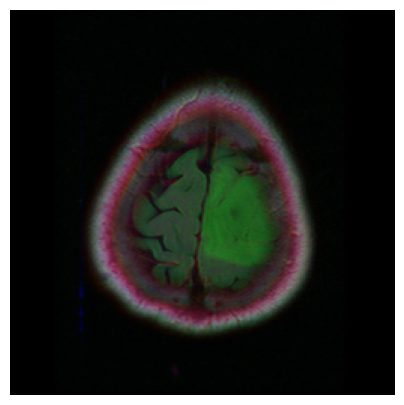

In [2]:
counter = 1
fig = plt.figure(figsize=(5, 5))
for img in img_array:
    fig.add_subplot(len(paths_to_image), 1, counter)
    plt.imshow(img)
    plt.axis('off')
    counter+=1

# Model tested in the images

In [3]:
def map_labels(index):
    return classes[index]

prediction = model.predict(img_array)
max_index_prediction = np.argmax(prediction, axis = 1)
classes = ["No tumour", "Tumour"]
#classes = np.array(classes, dtype = 'U30')
pred_class = [map_labels(i) for i in max_index_prediction]

pred_class

1/1 [==============================] - 2s 2s/step


['Tumour']

# Shap explanation

In [4]:
import shap
shap.initjs()
explainers = []
masks = ['blur(64,64)']

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


  0%|          | 0/1998 [00:00<?, ?it/s]

Partition explainer: 2it [04:19, 259.09s/it]                                                                                                               


blur(64,64)


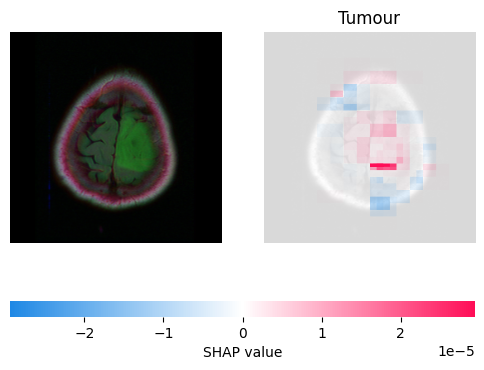

In [5]:
shap_values = {}
for mask in masks:
    shap_values_array= []
    masker = shap.maskers.Image(mask, shape=img_array[0].shape) 
    explainer=shap.Explainer(model, masker, output_names=classes, seed = 42)
    for img in img_array:
        shap_values_array.append(explainer(np.expand_dims(img, axis = 0), max_evals = 2000, batch_size = 50, outputs=shap.Explanation.argsort.flip[:1]))
    shap_values[mask] = shap_values_array
    
for mask in masks:
    print(mask)
    for shap_value in shap_values[mask]:
        shap.image_plot(shap_value)

(1, 256, 256, 3)
(256, 256)
1/1 [==============================] - 0s 195ms/step
[[9.9999952e-01 4.9415354e-07]]
1/1 [==============================] - 0s 190ms/step
[[9.9999940e-01 5.9236356e-07]]
1/1 [==============================] - 0s 193ms/step
[[9.9999917e-01 8.8432080e-07]]
1/1 [==============================] - 0s 195ms/step
[[9.9999869e-01 1.3282504e-06]]
1/1 [==============================] - 0s 181ms/step
[[9.999980e-01 2.073803e-06]]
1/1 [==============================] - 0s 196ms/step
[[9.999976e-01 2.431838e-06]]
1/1 [==============================] - 0s 196ms/step
[[9.9999654e-01 3.4755326e-06]]
1/1 [==============================] - 0s 194ms/step
[[9.9999475e-01 5.2200307e-06]]
1/1 [==============================] - 0s 195ms/step
[[9.9999475e-01 5.2591658e-06]]
1/1 [==============================] - 0s 196ms/step
[[9.999945e-01 5.452169e-06]]
1/1 [==============================] - 0s 197ms/step
[[9.9999440e-01 5.6087397e-06]]
1/1 [==============================] - 0s 1

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


1/1 [==============================] - 0s 187ms/step
[[9.9998581e-01 1.4193056e-05]]
1/1 [==============================] - 0s 194ms/step
[[9.9998391e-01 1.6109256e-05]]
1/1 [==============================] - 0s 201ms/step
[[9.999777e-01 2.226813e-05]]
1/1 [==============================] - 0s 190ms/step
[[9.9997795e-01 2.2044498e-05]]
1/1 [==============================] - 0s 181ms/step
[[9.9997246e-01 2.7546539e-05]]
1/1 [==============================] - 0s 192ms/step
[[9.9997199e-01 2.8049224e-05]]
1/1 [==============================] - 0s 189ms/step
[[9.9997544e-01 2.4541208e-05]]
1/1 [==============================] - 0s 187ms/step
[[9.9994671e-01 5.3236374e-05]]
1/1 [==============================] - 0s 188ms/step
[[9.999362e-01 6.383035e-05]]
1/1 [==============================] - 0s 200ms/step
[[9.9991119e-01 8.8825436e-05]]
1/1 [==============================] - 0s 192ms/step
[[9.9990082e-01 9.9180914e-05]]
1/1 [==============================] - 0s 181ms/step
[[9.9989808e-01 

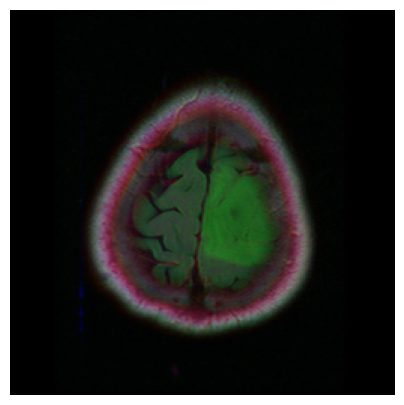

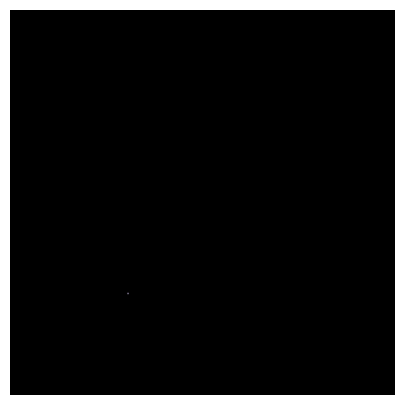

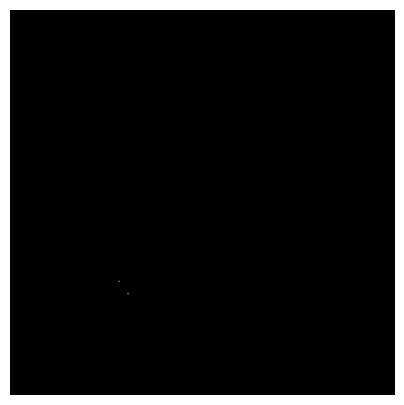

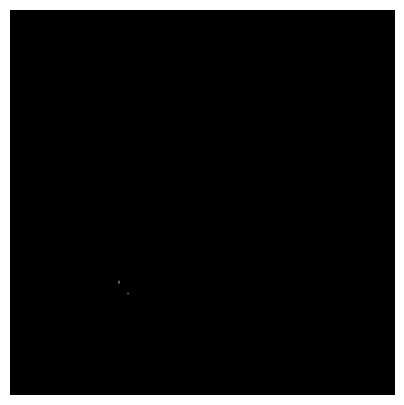

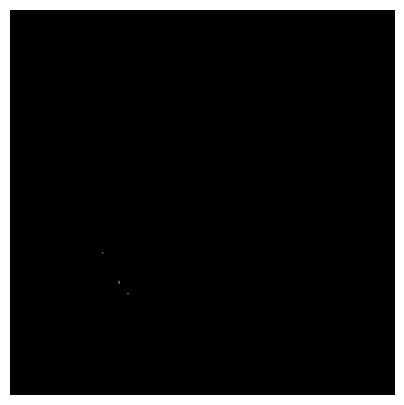

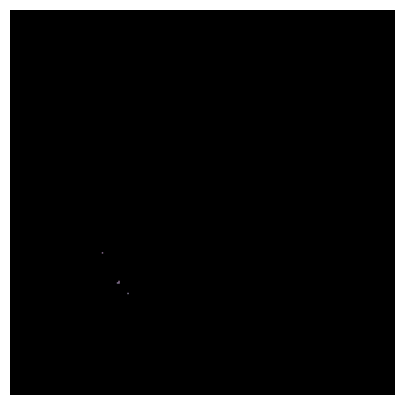

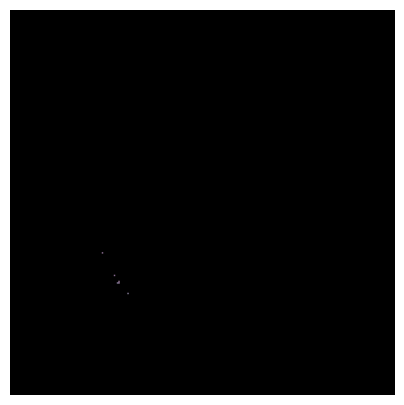

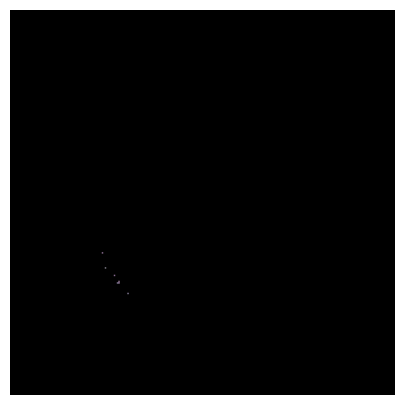

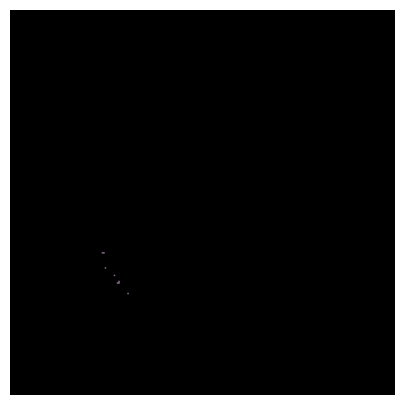

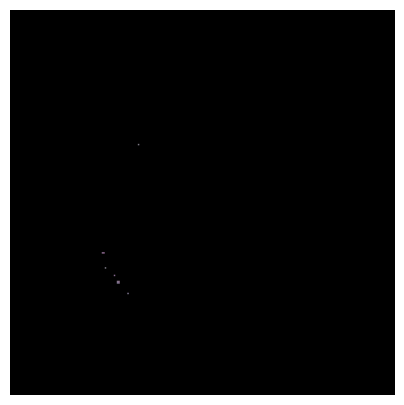

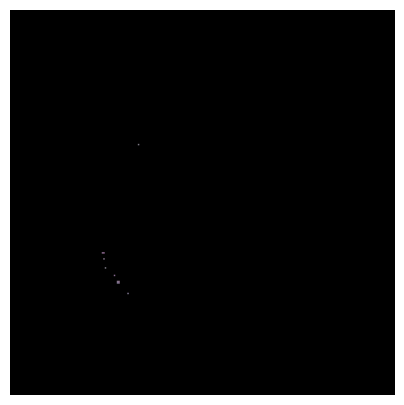

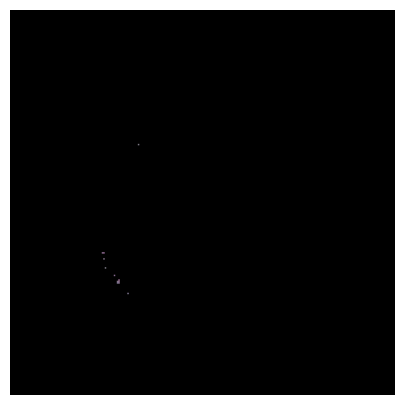

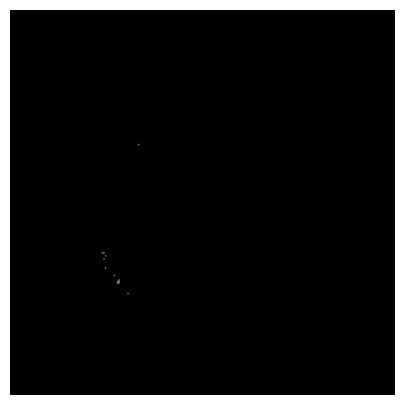

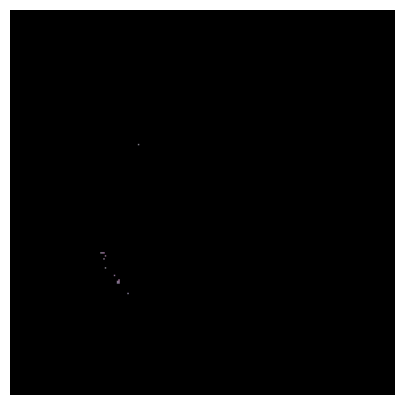

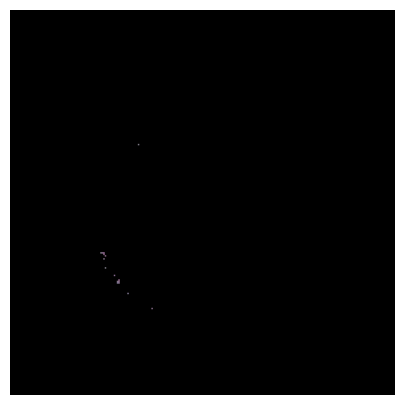

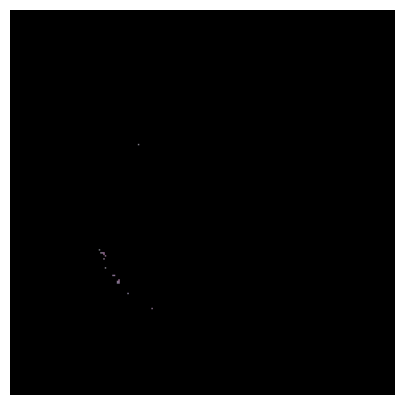

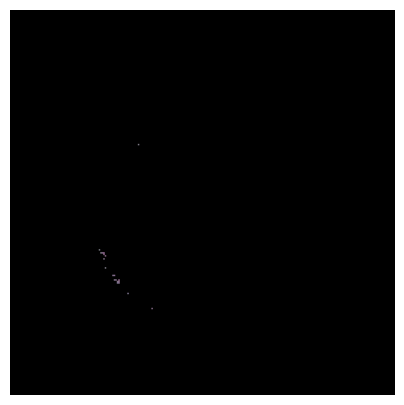

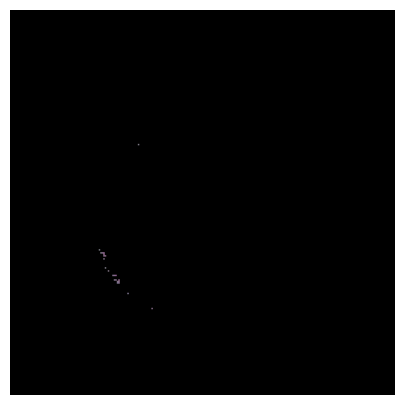

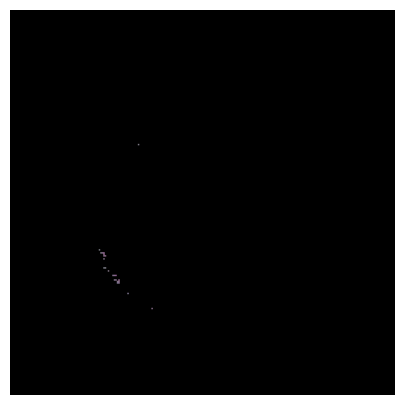

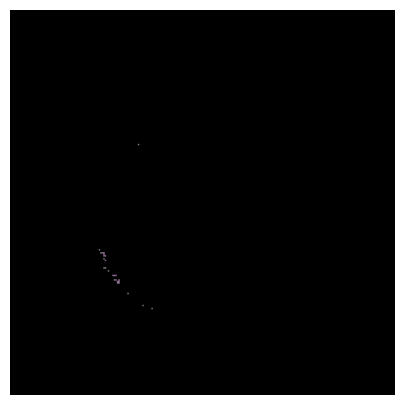

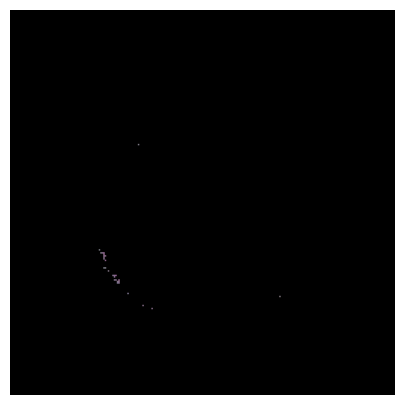

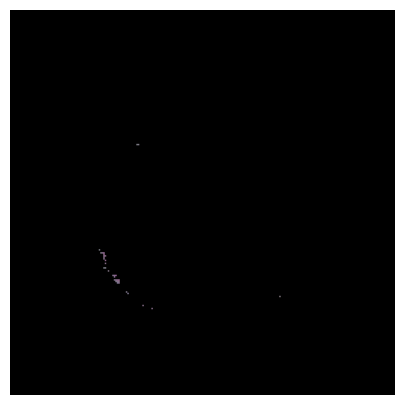

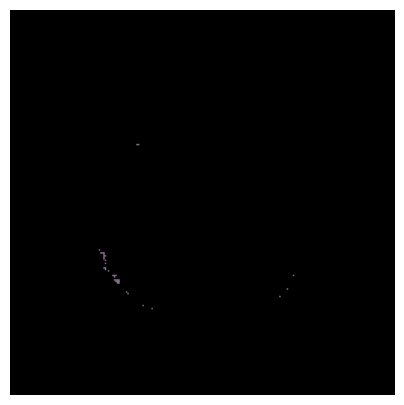

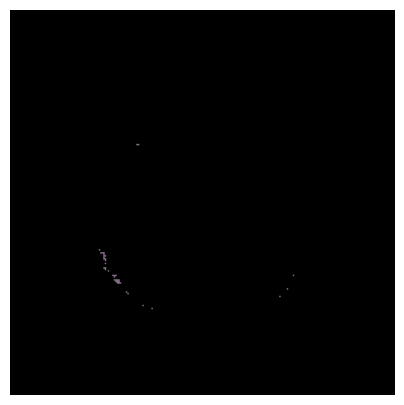

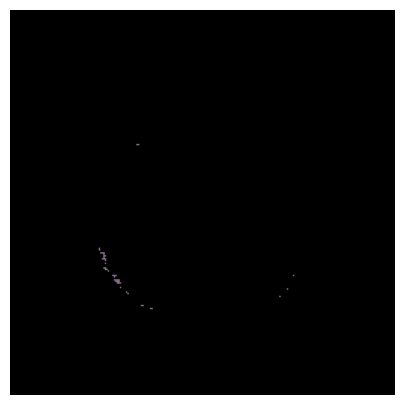

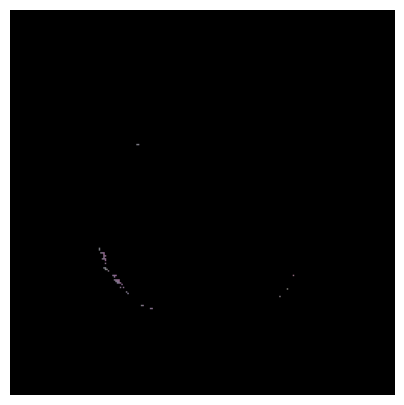

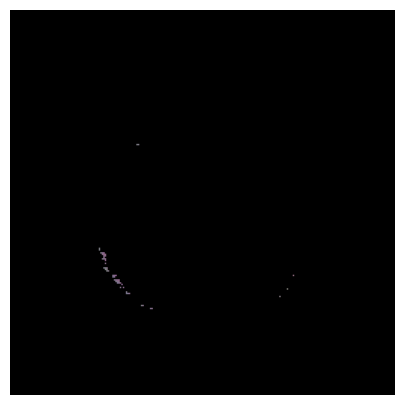

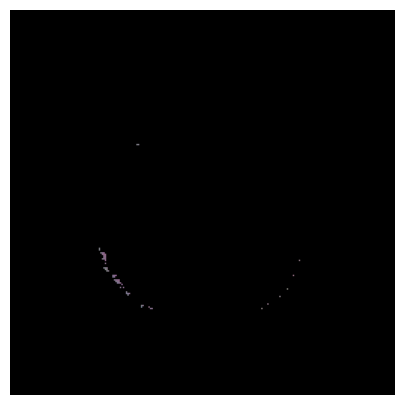

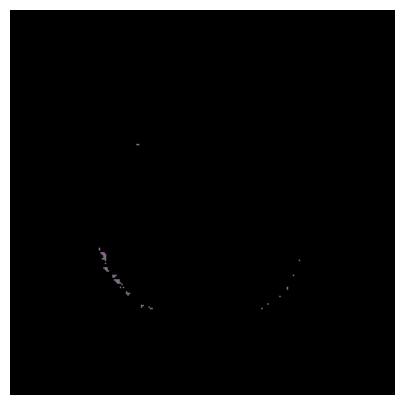

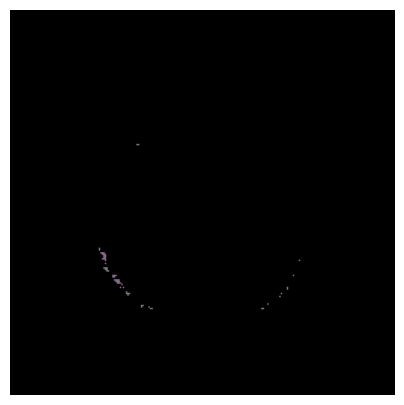

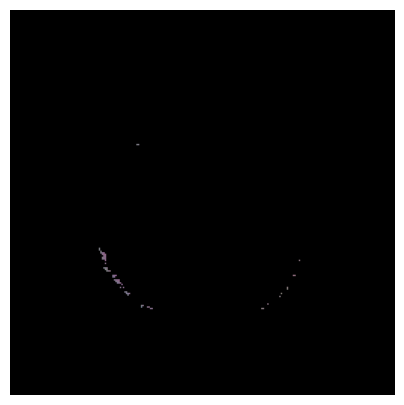

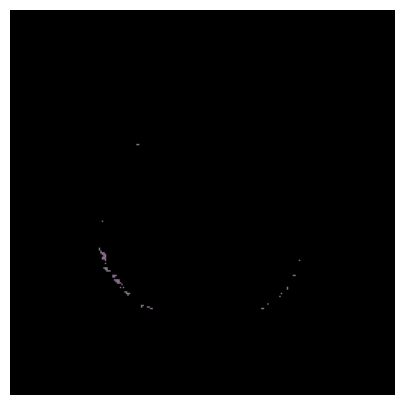

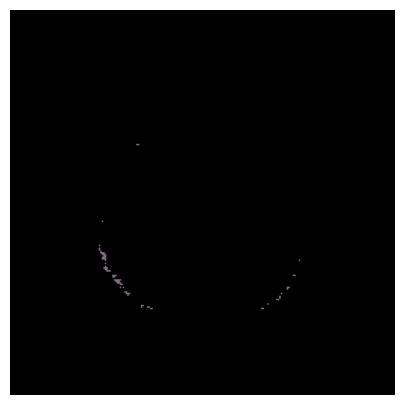

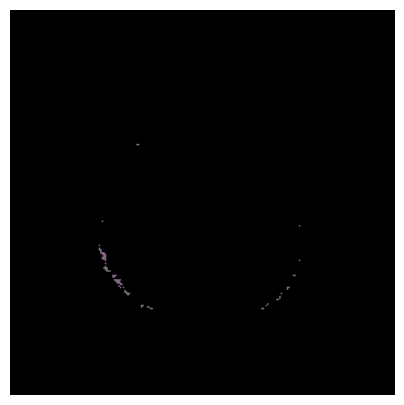

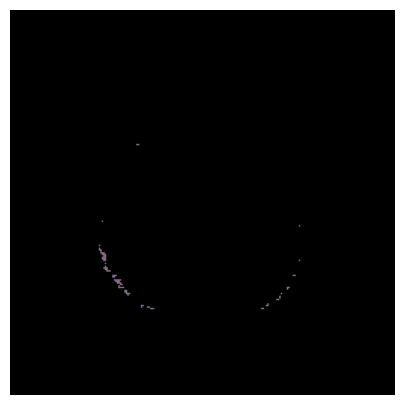

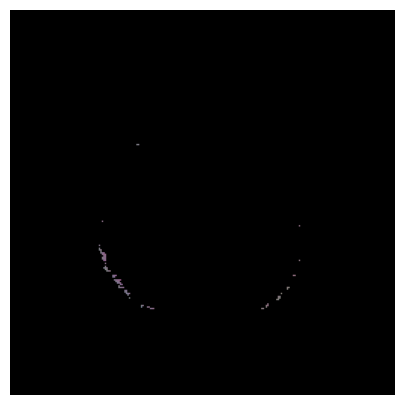

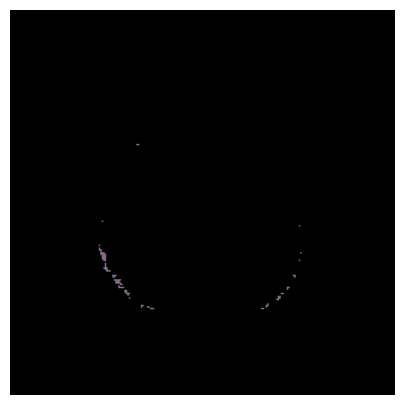

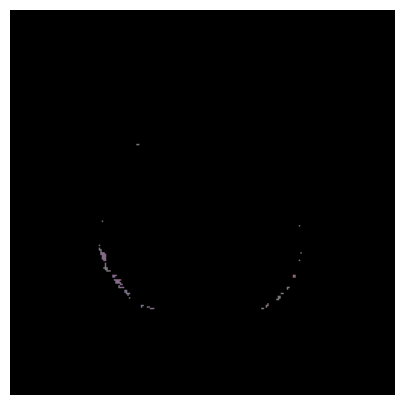

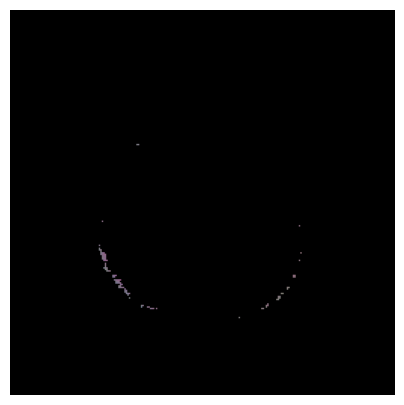

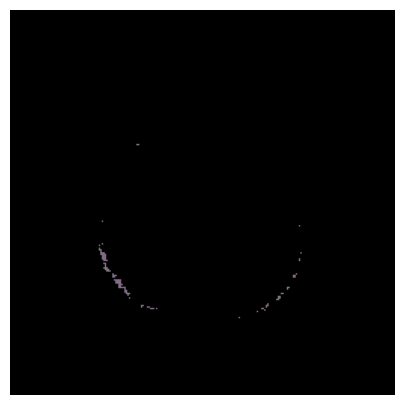

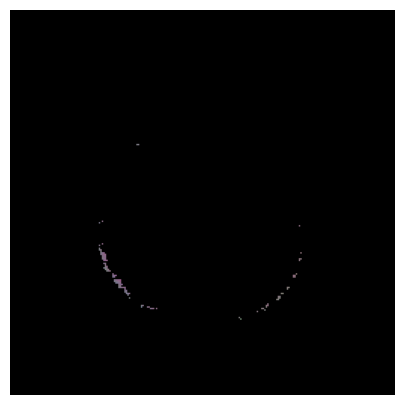

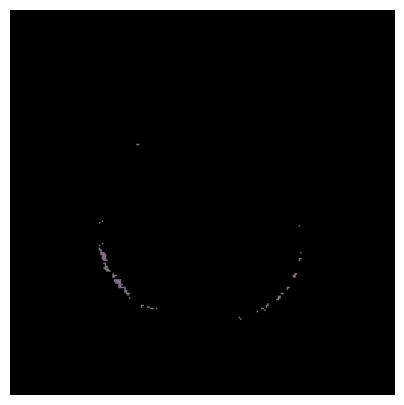

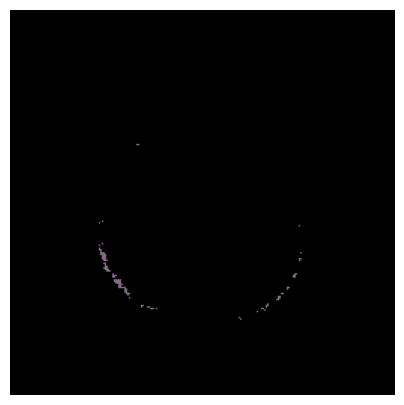

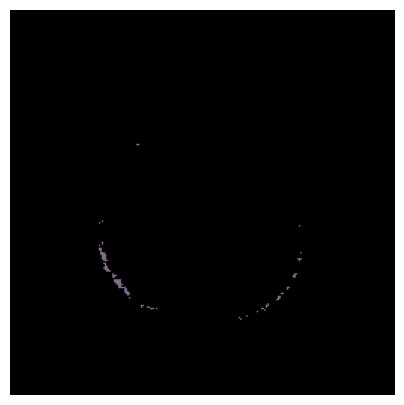

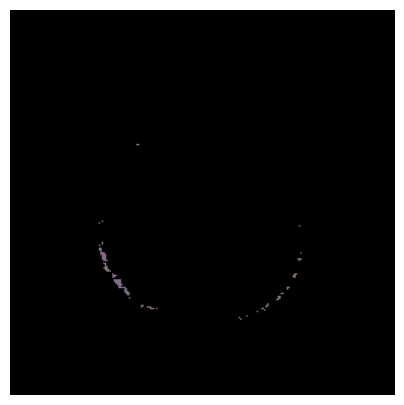

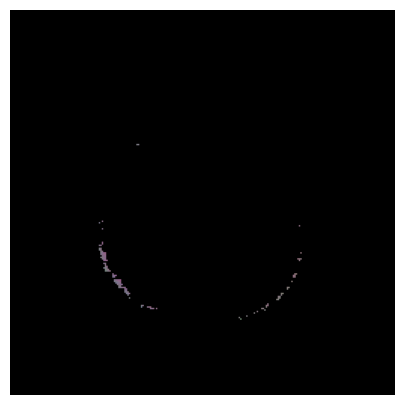

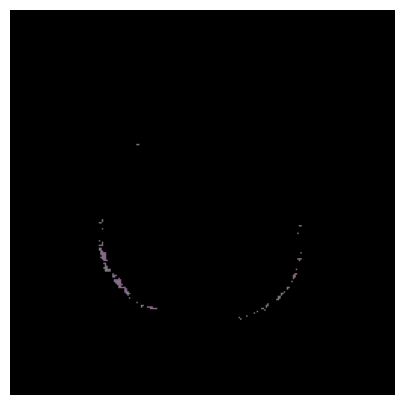

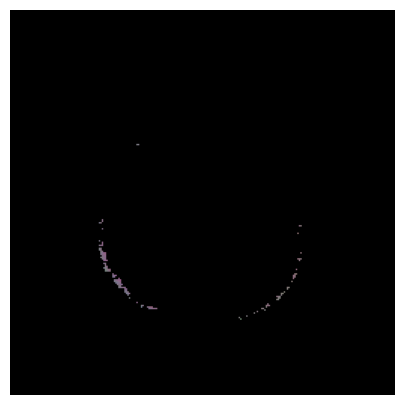

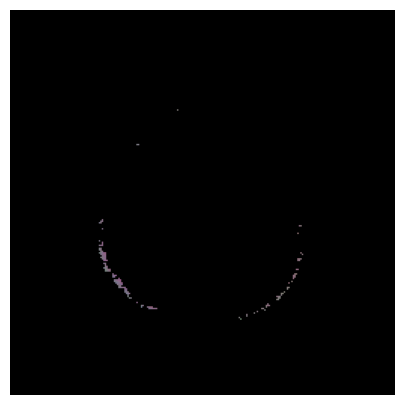

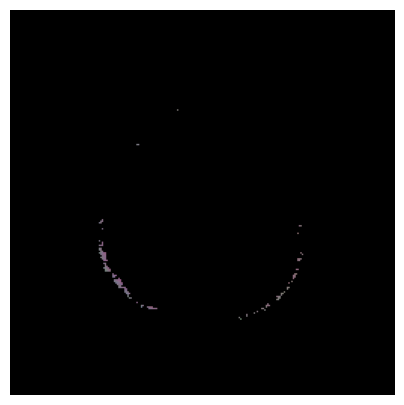

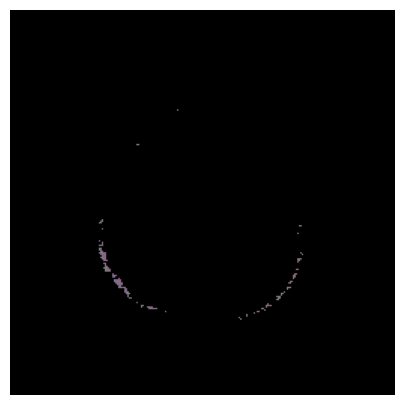

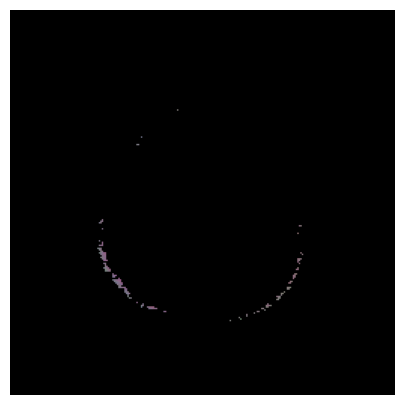

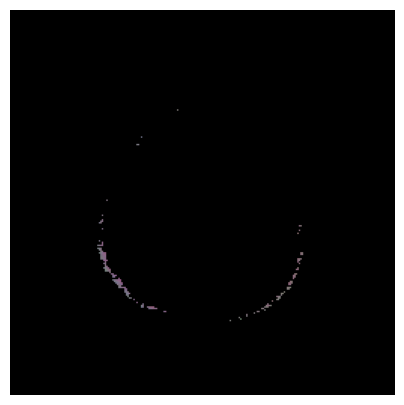

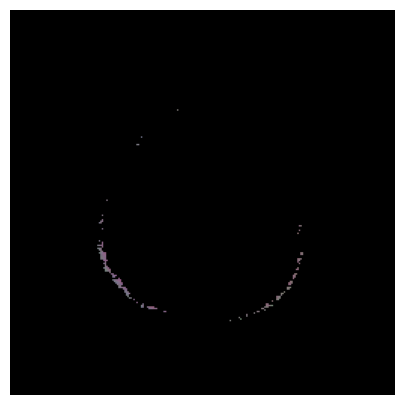

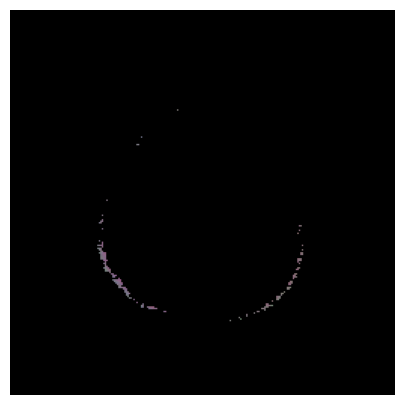

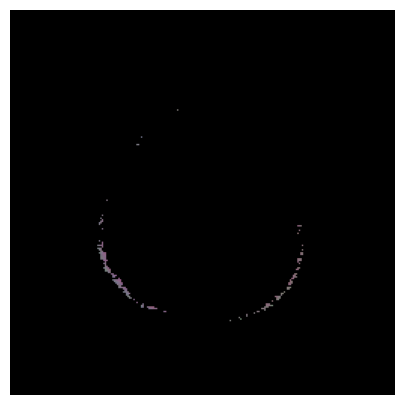

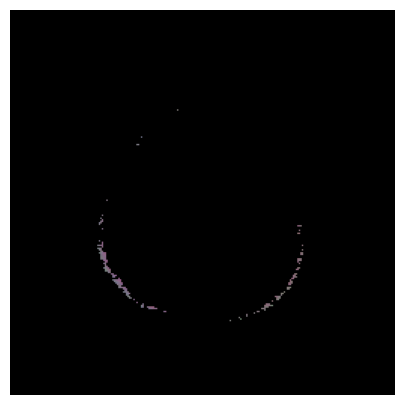

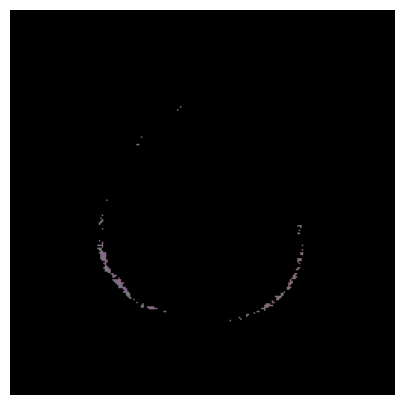

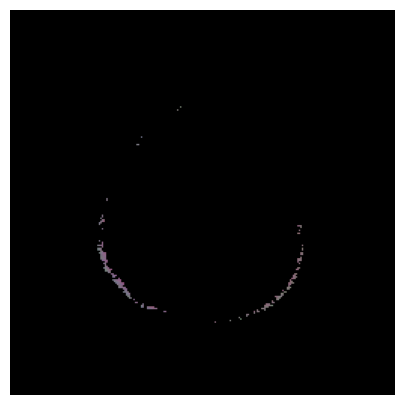

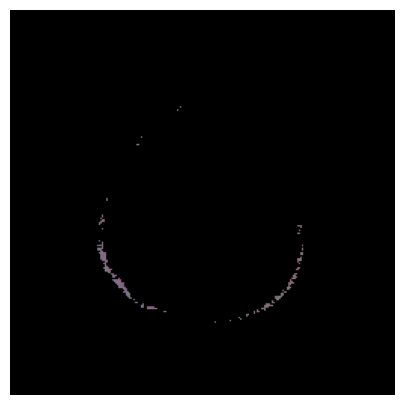

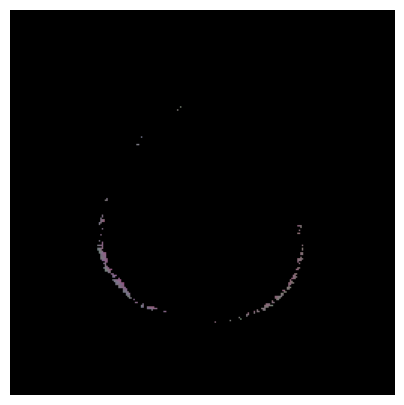

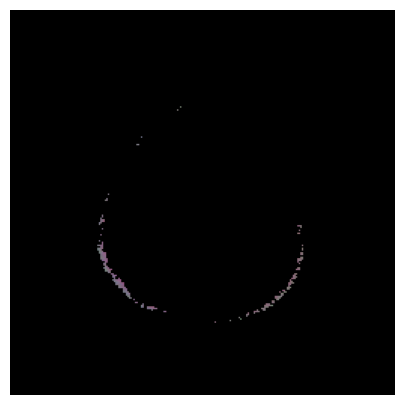

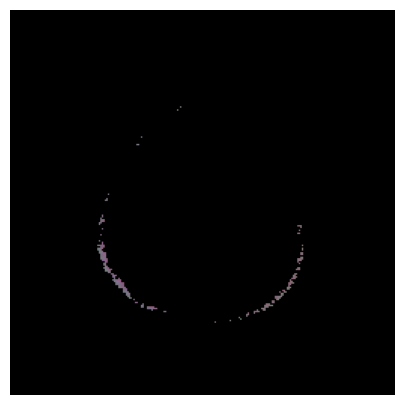

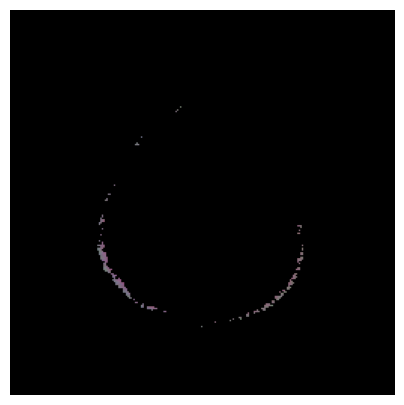

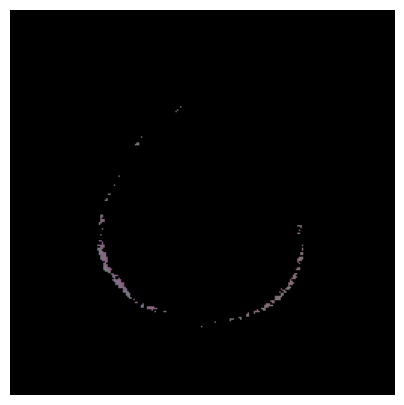

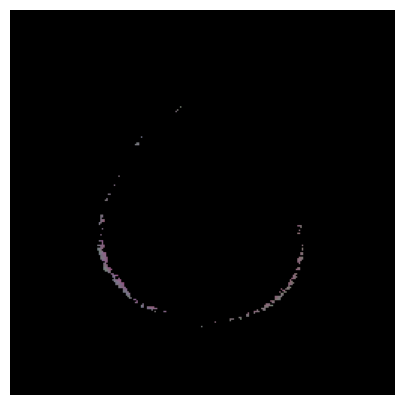

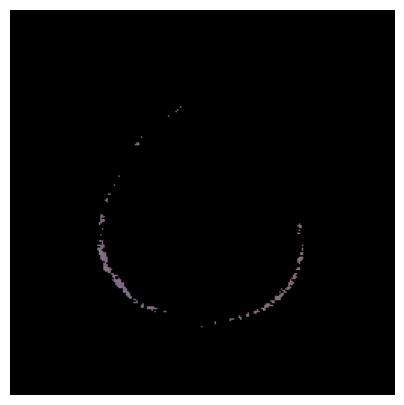

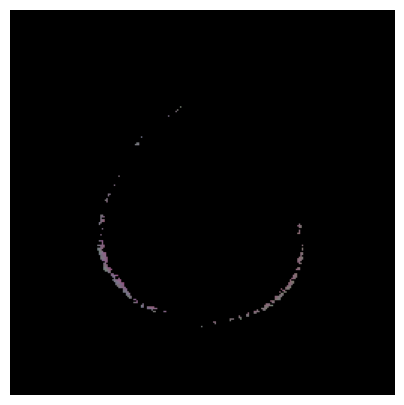

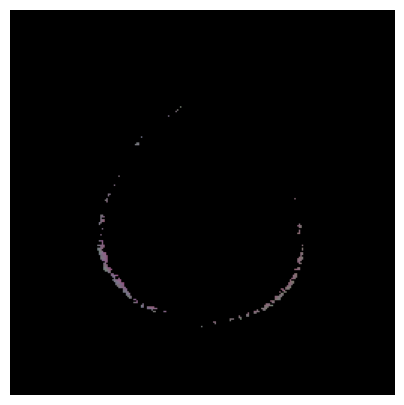

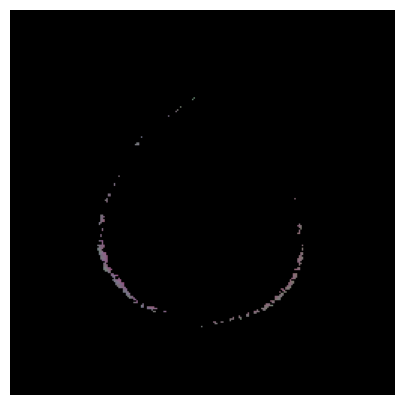

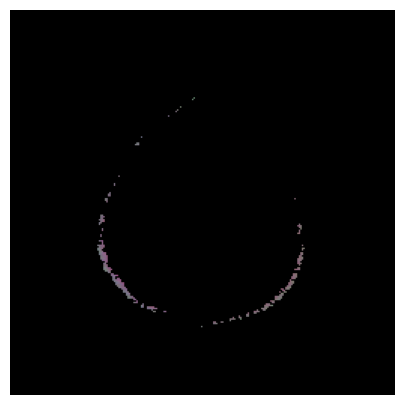

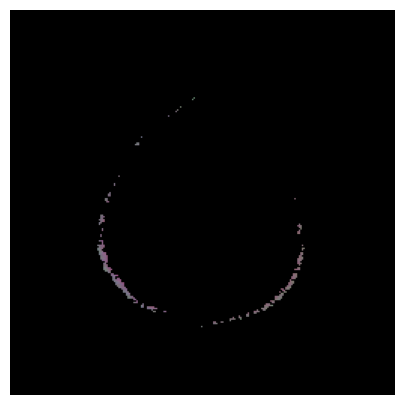

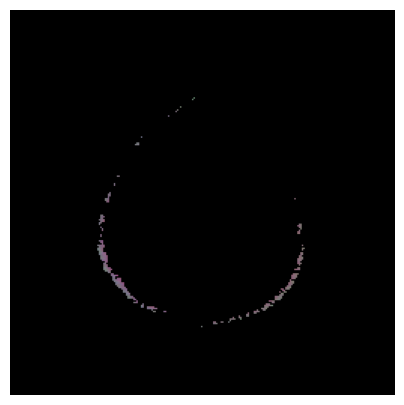

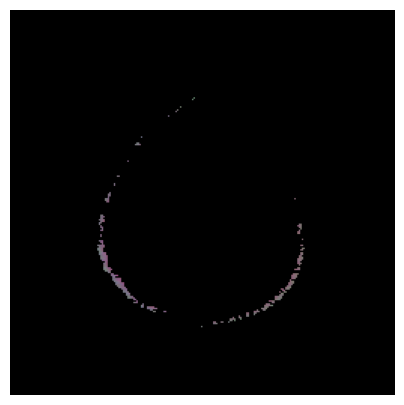

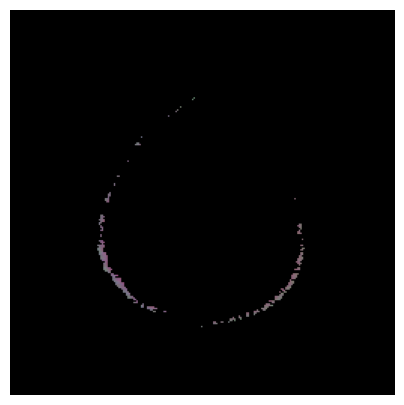

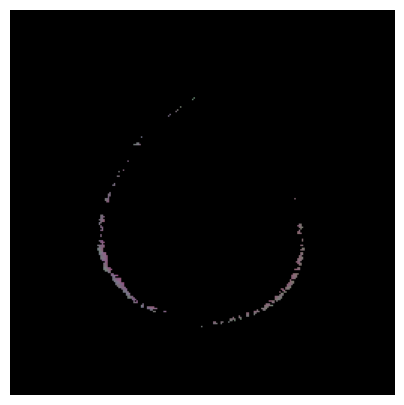

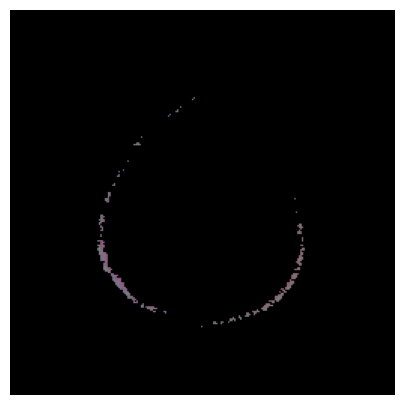

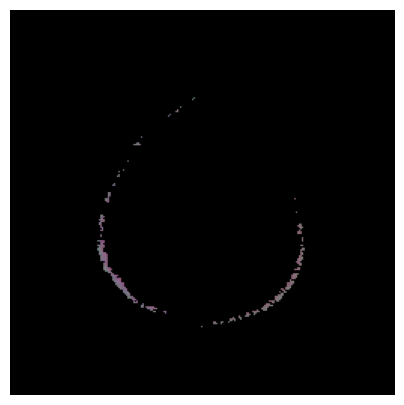

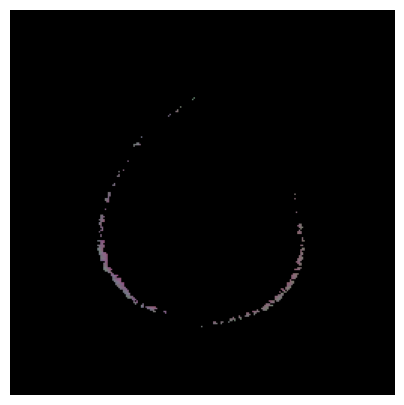

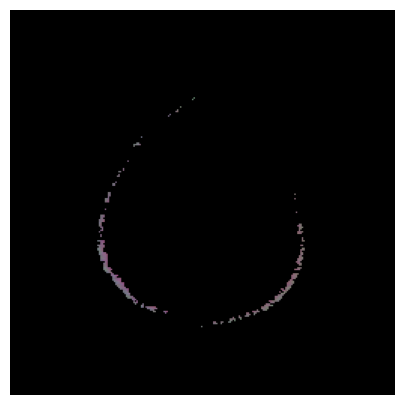

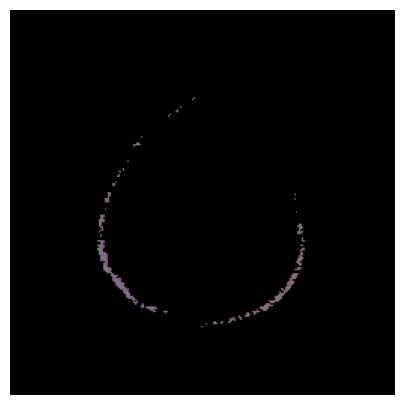

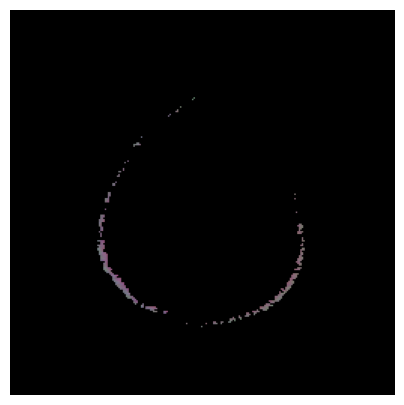

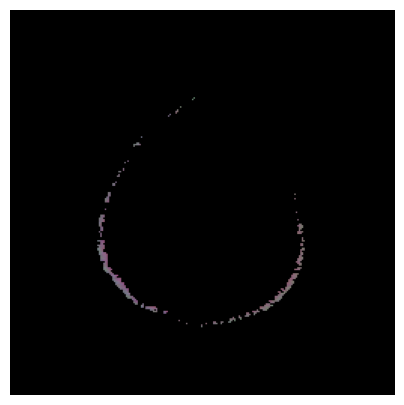

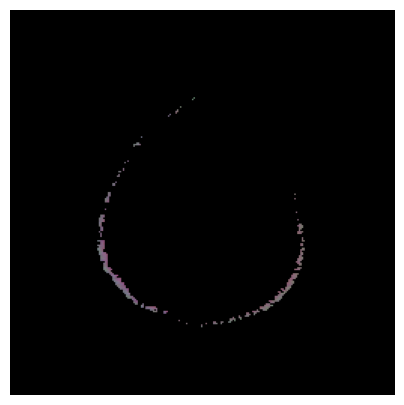

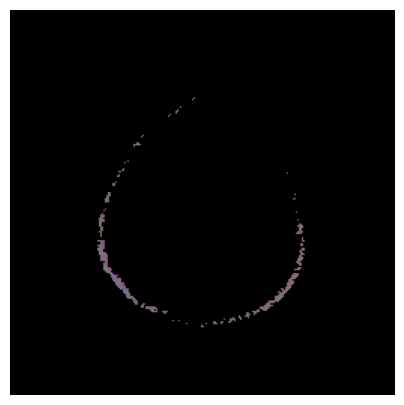

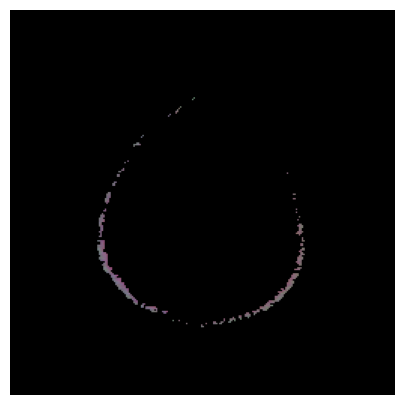

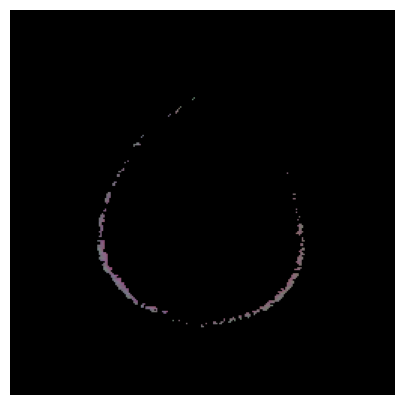

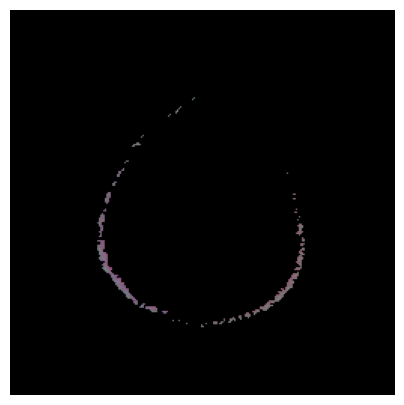

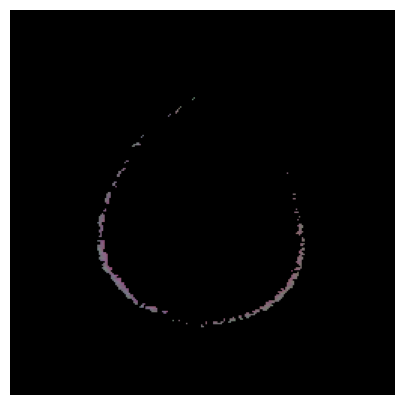

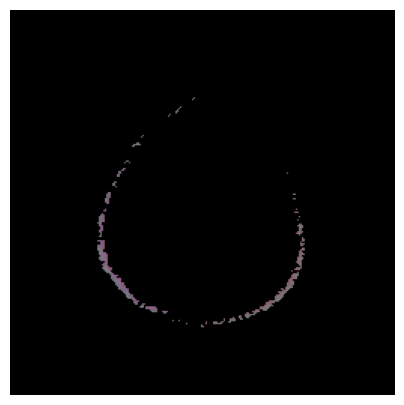

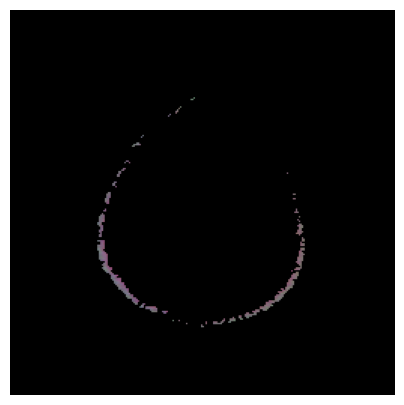

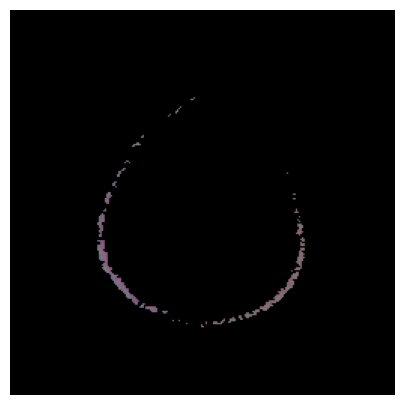

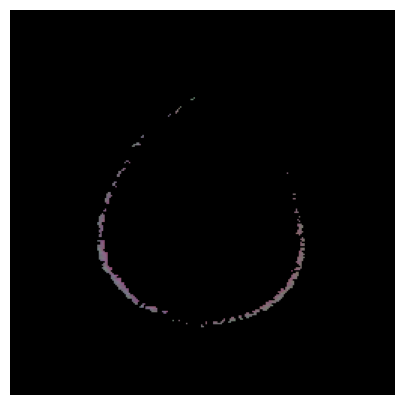

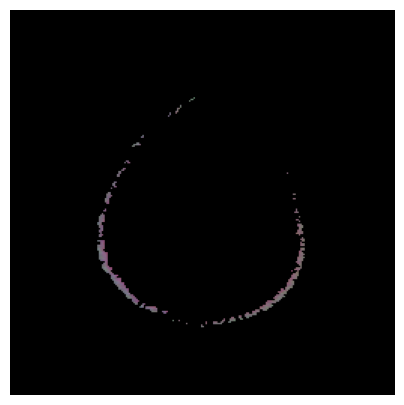

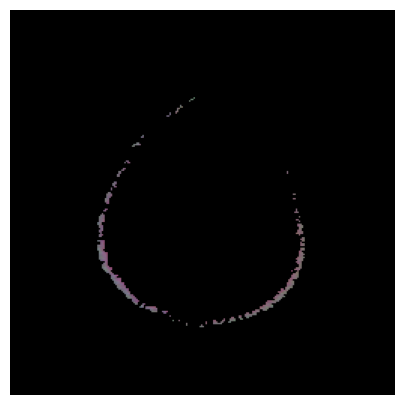

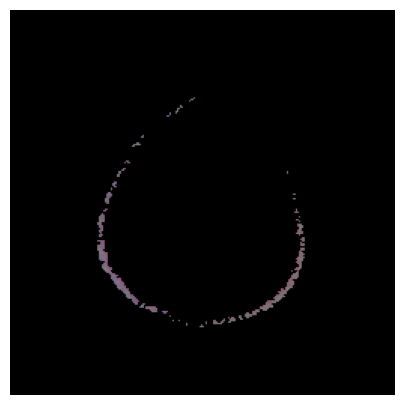

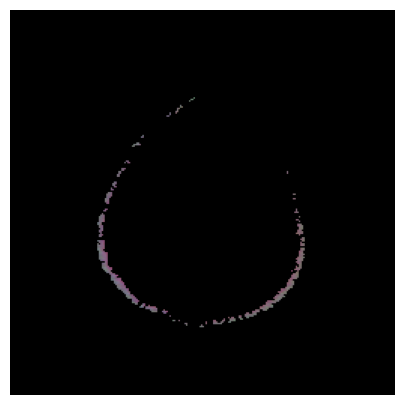

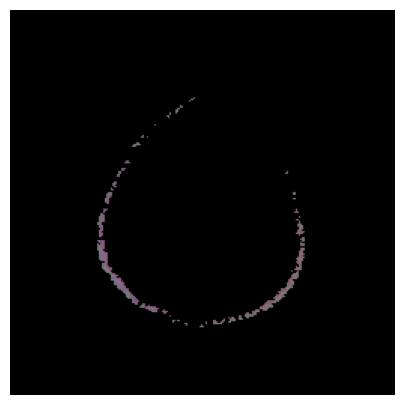

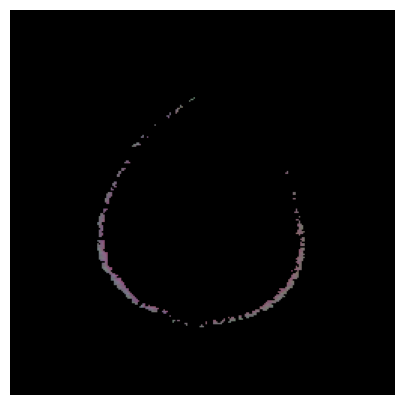

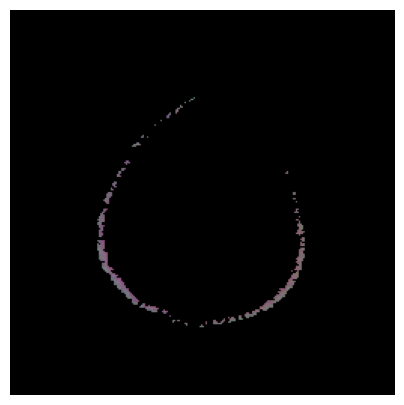

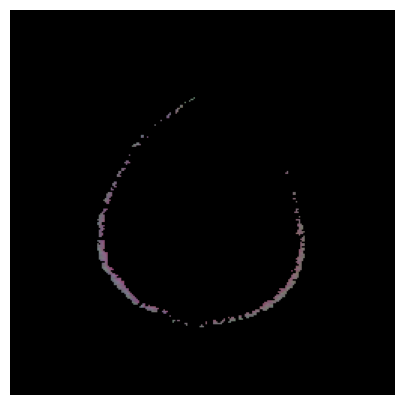

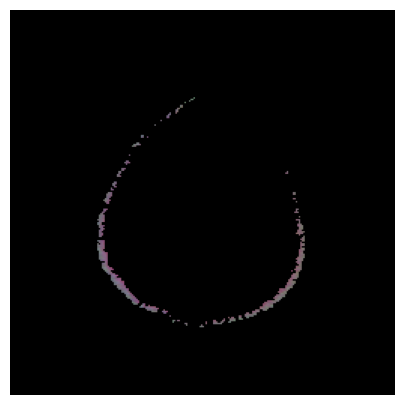

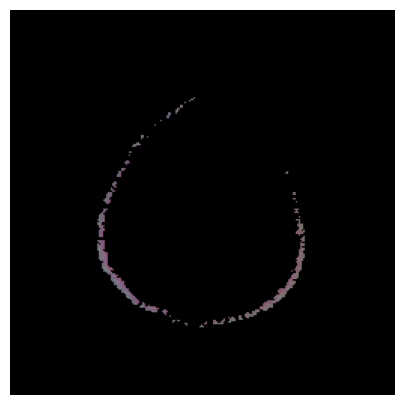

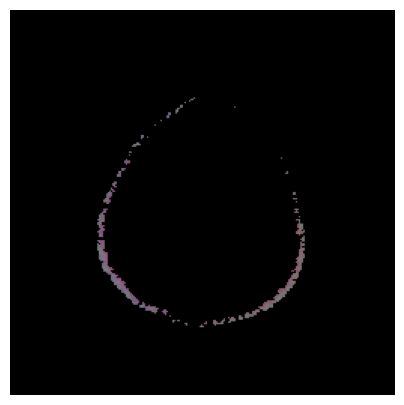

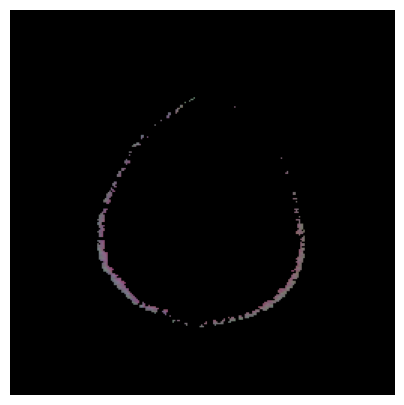

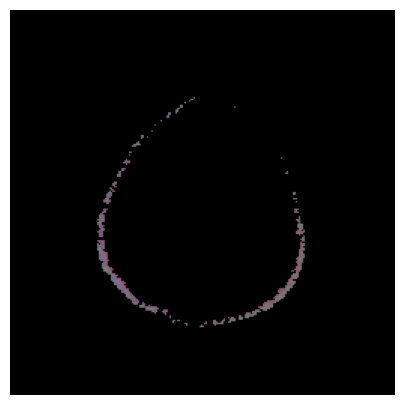

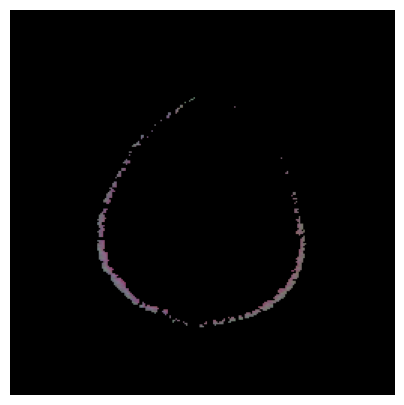

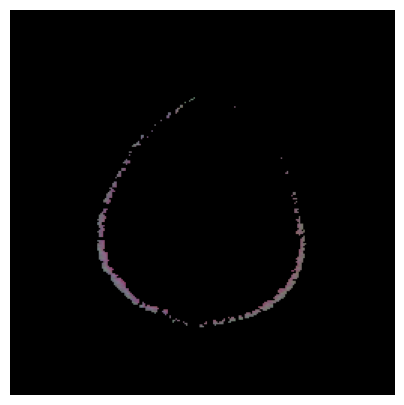

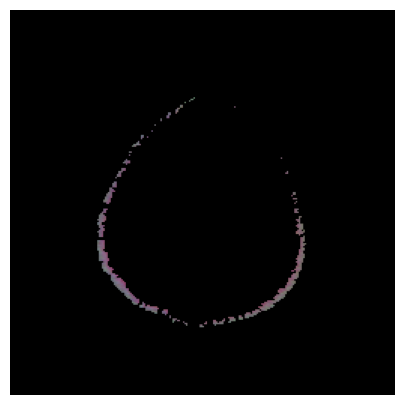

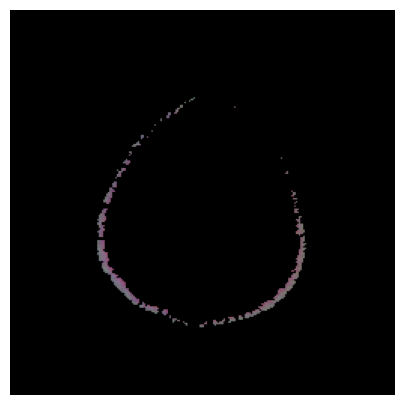

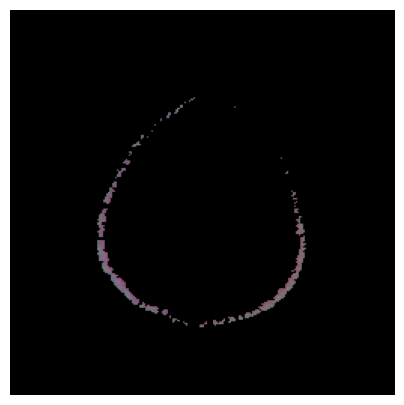

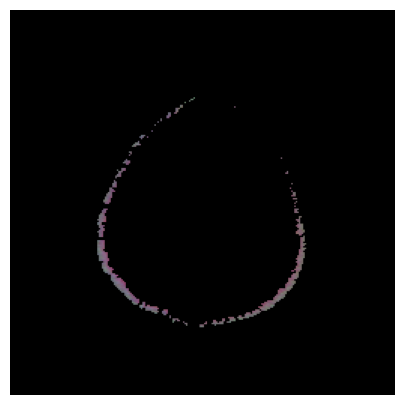

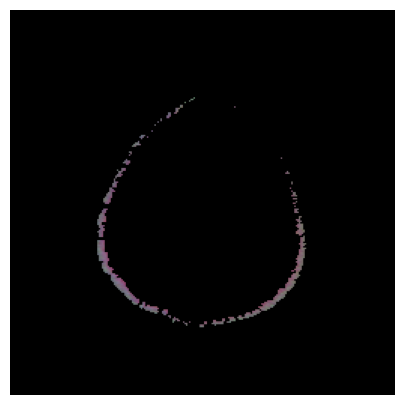

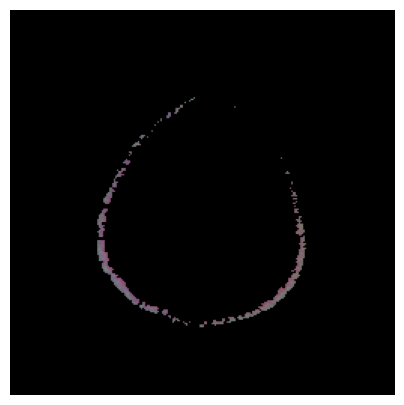

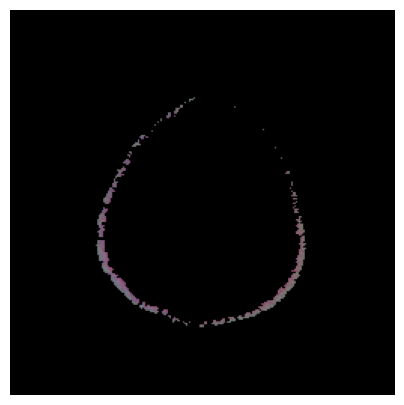

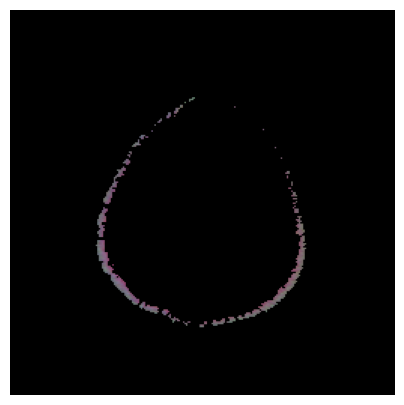

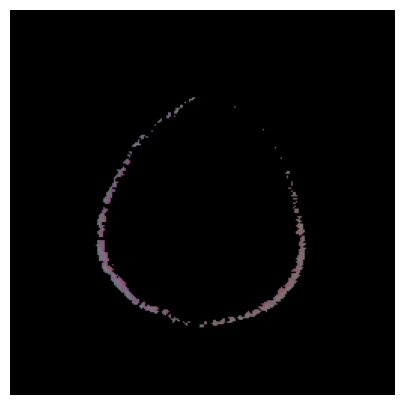

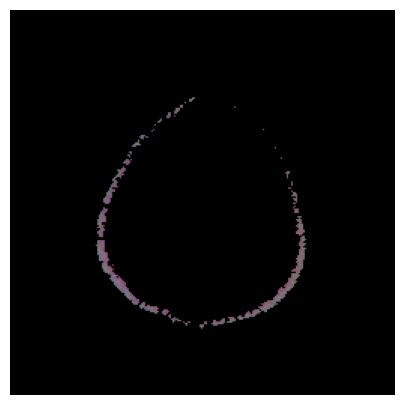

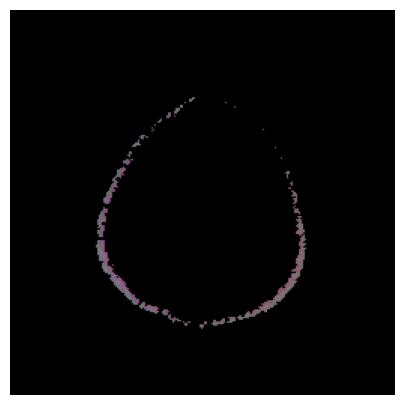

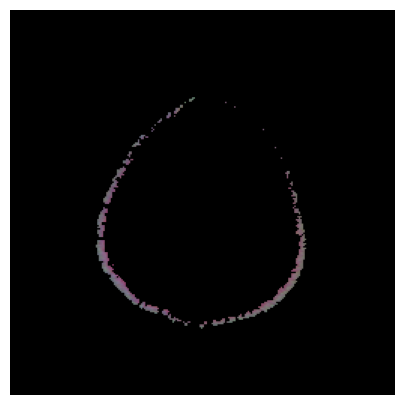

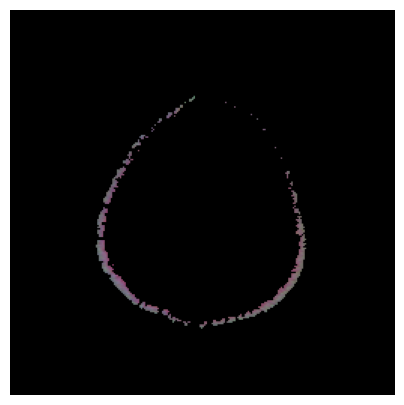

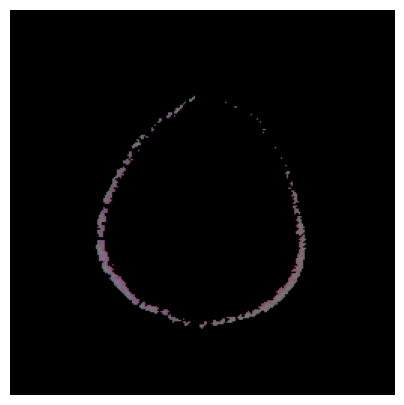

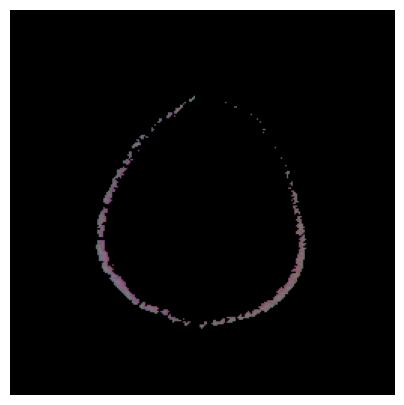

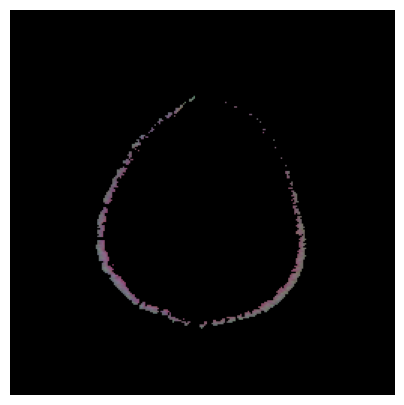

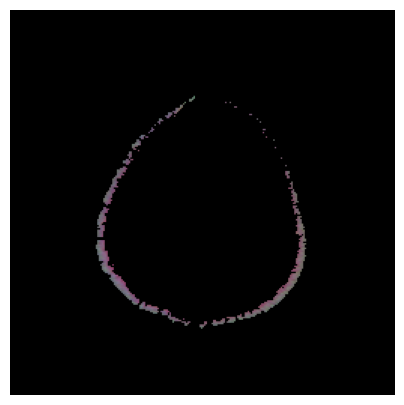

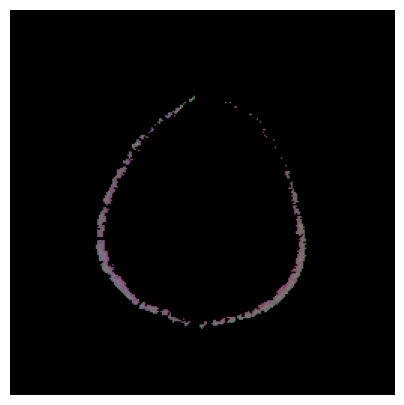

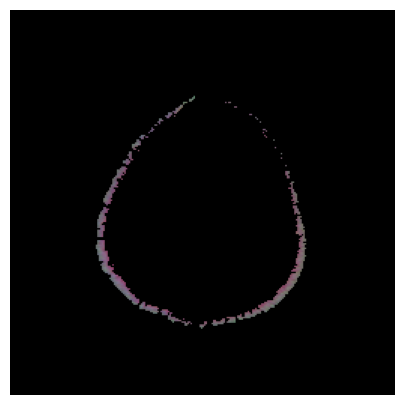

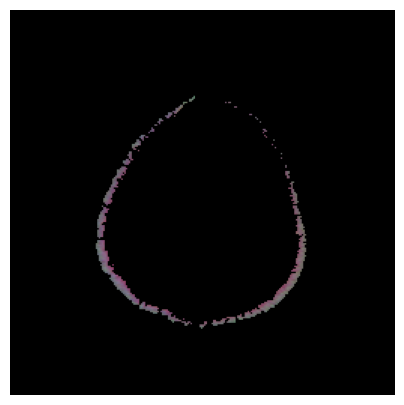

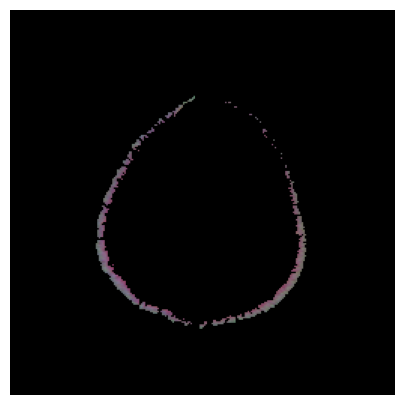

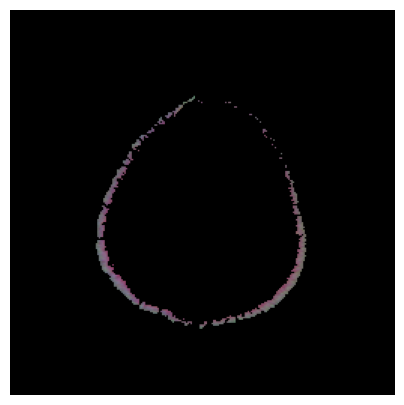

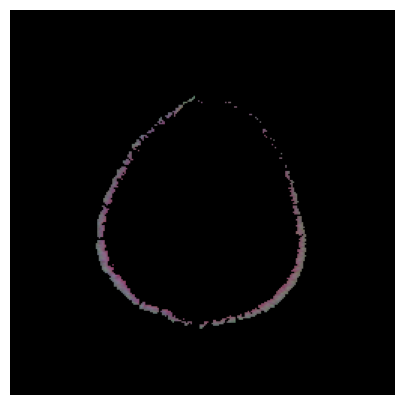

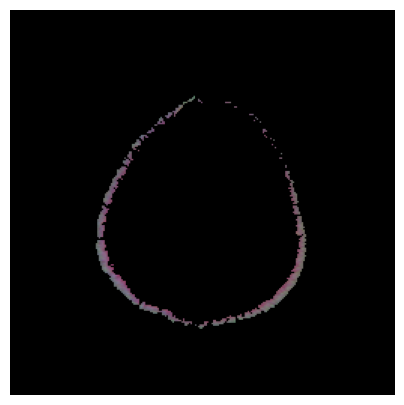

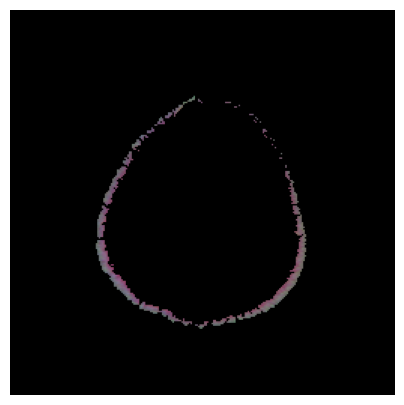

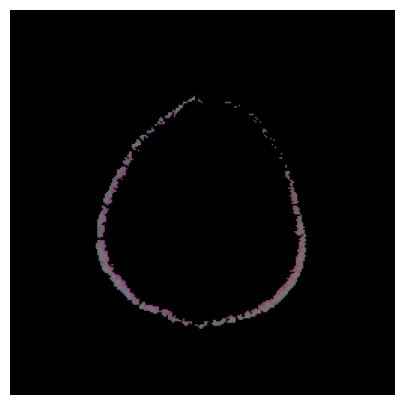

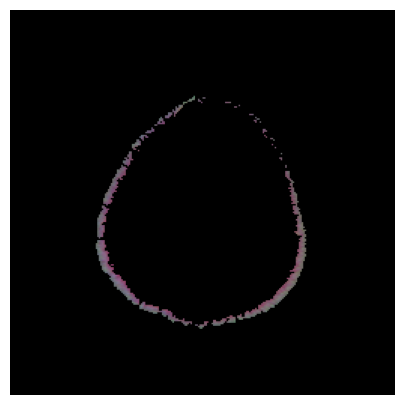

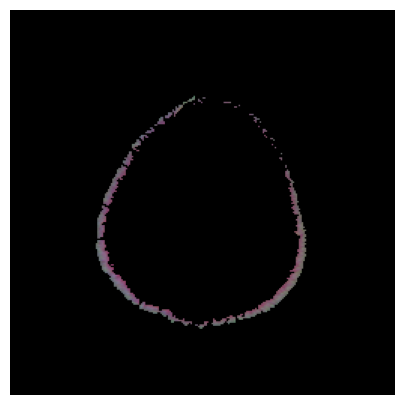

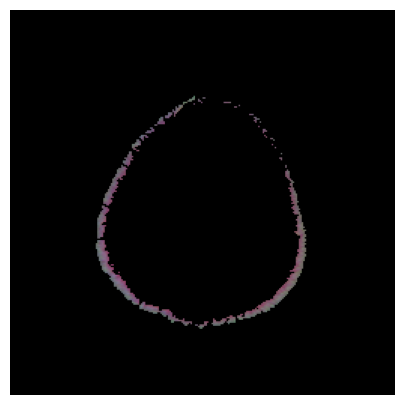

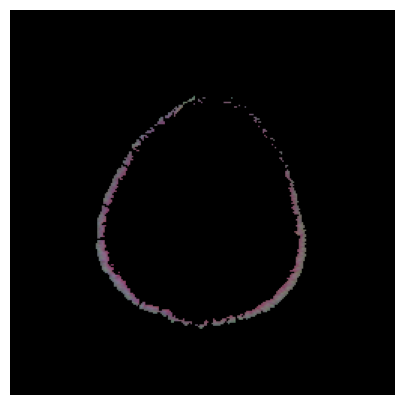

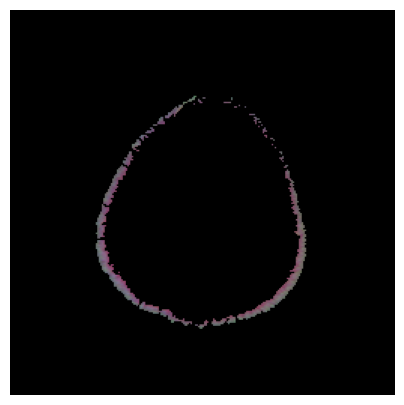

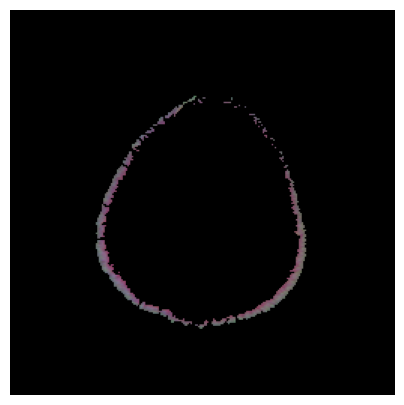

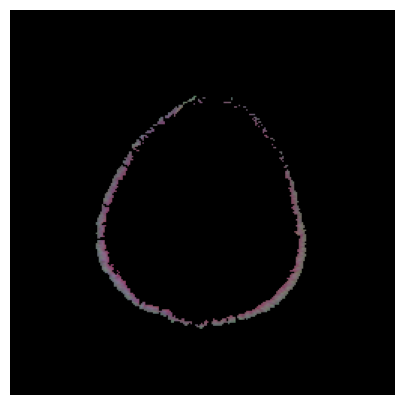

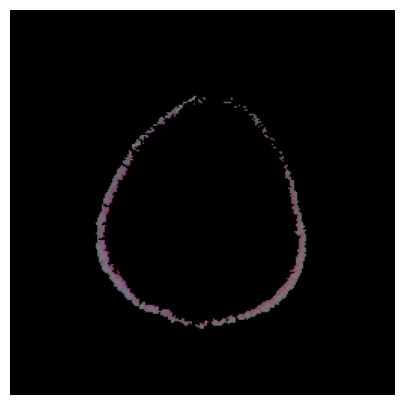

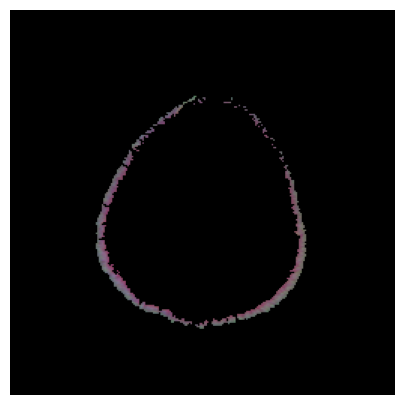

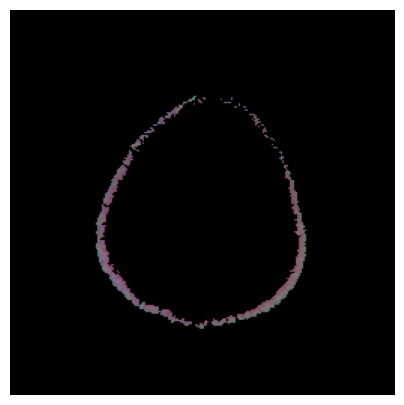

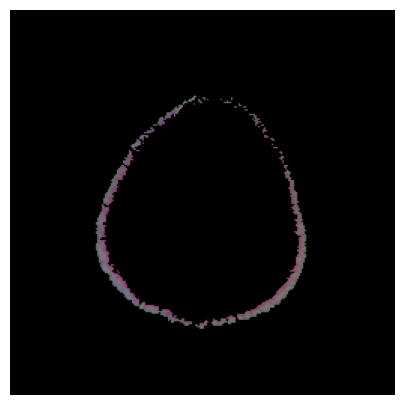

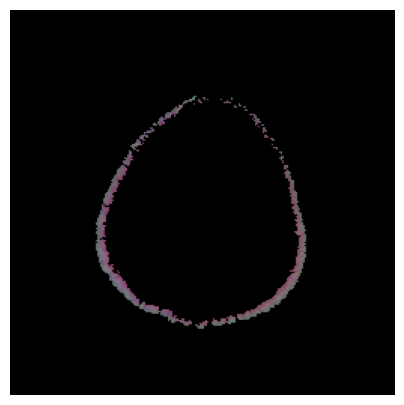

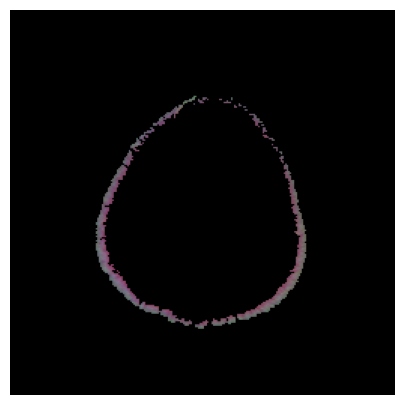

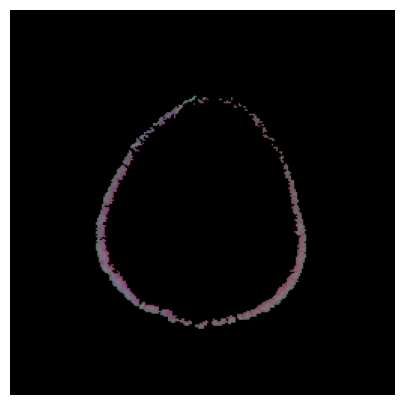

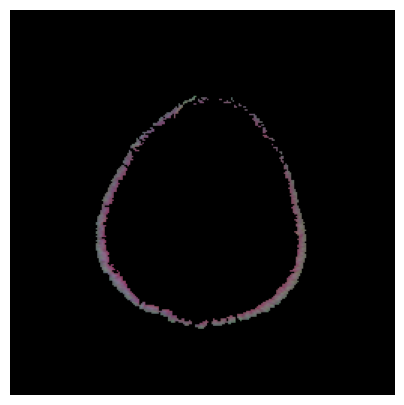

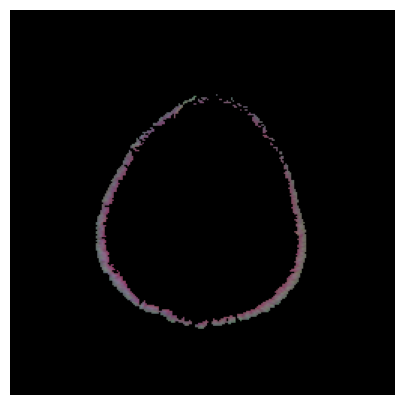

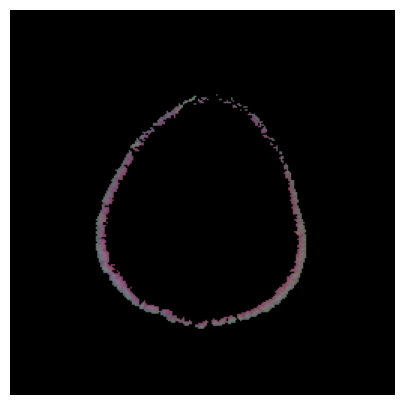

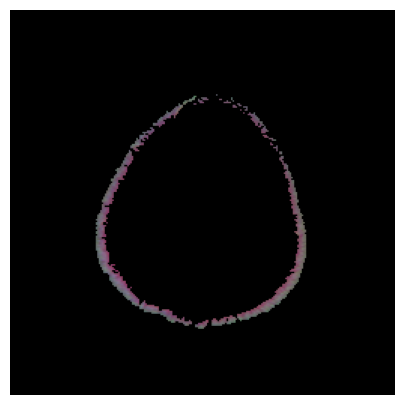

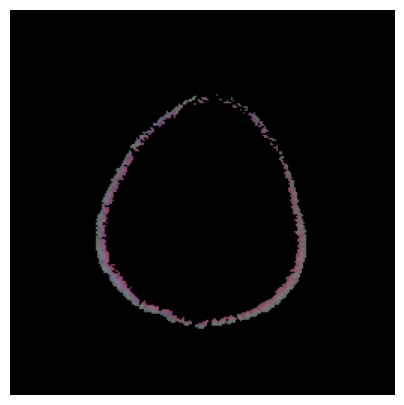

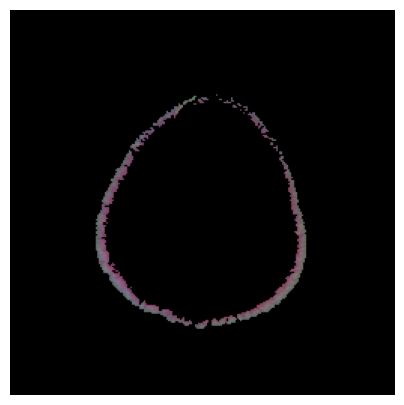

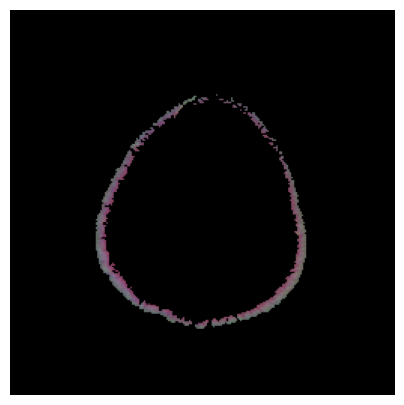

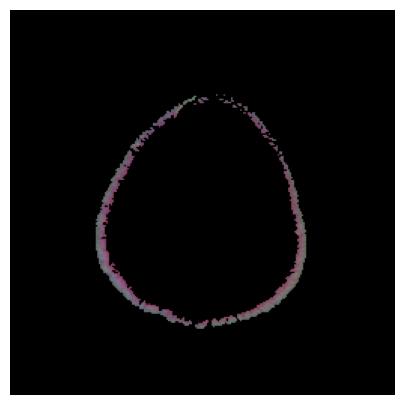

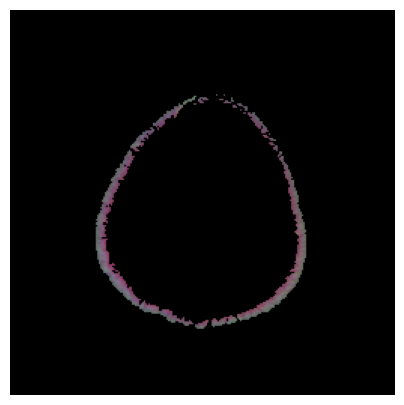

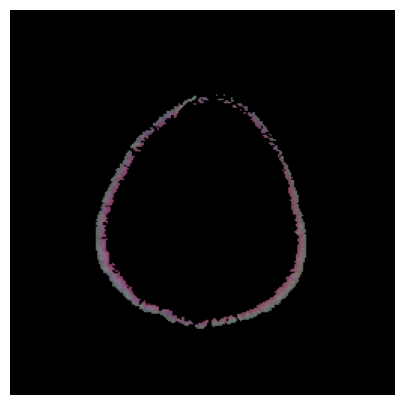

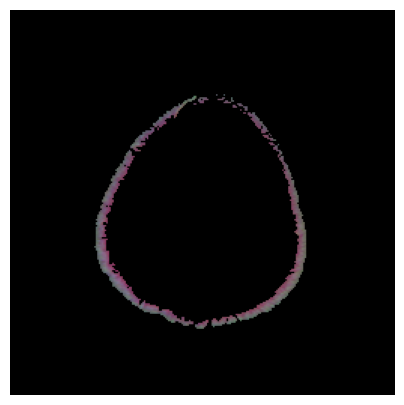

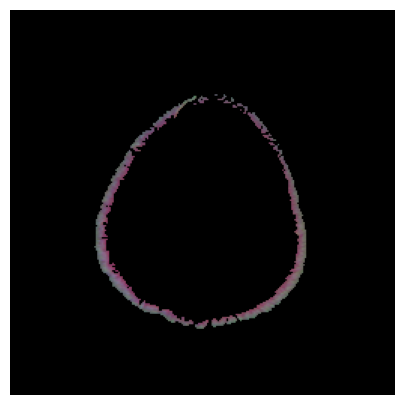

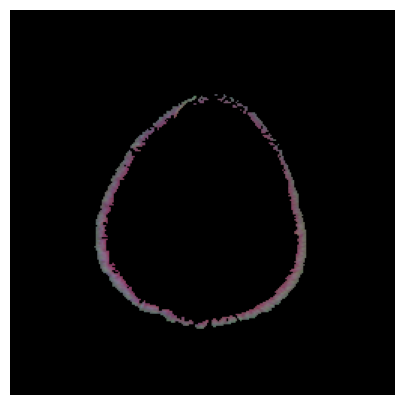

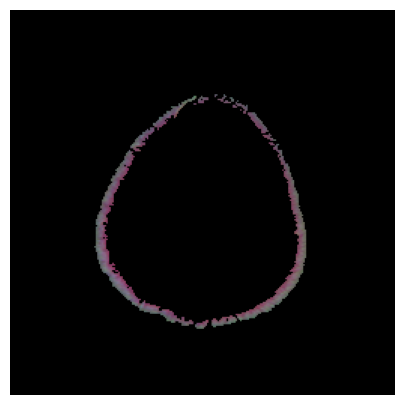

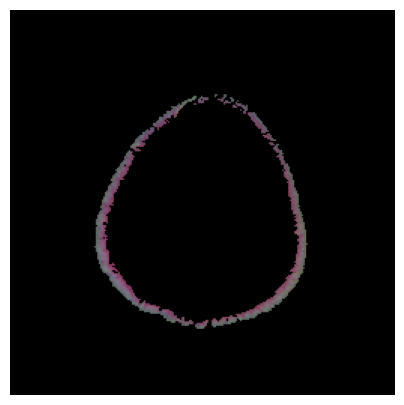

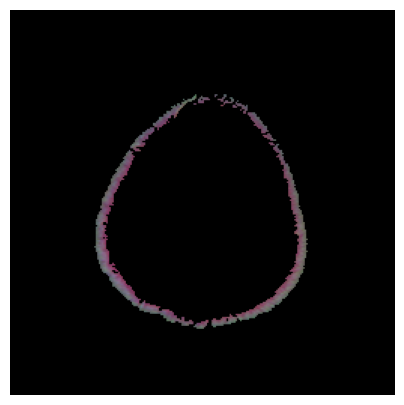

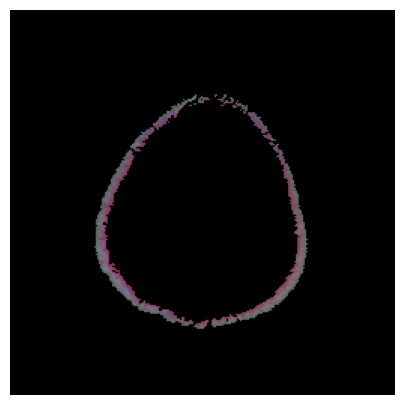

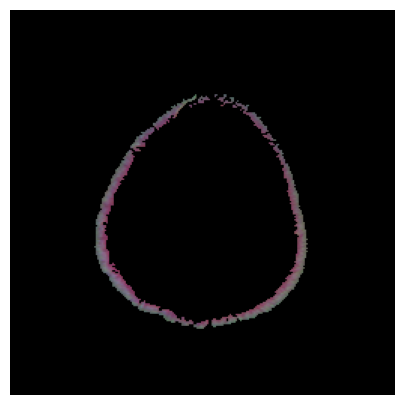

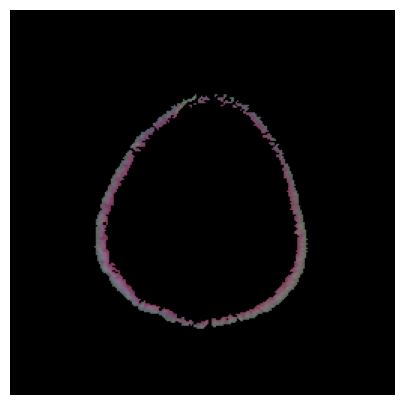

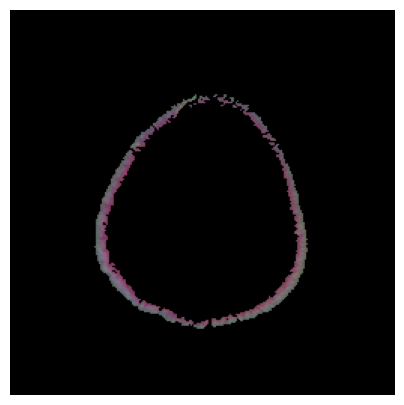

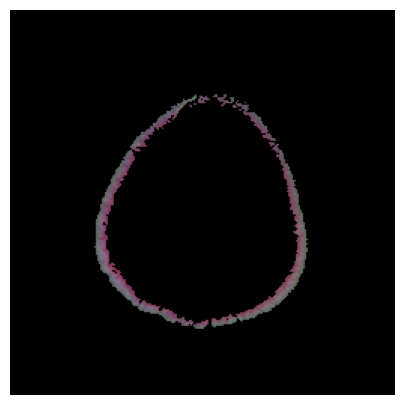

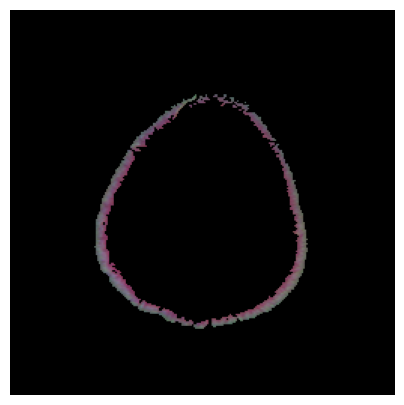

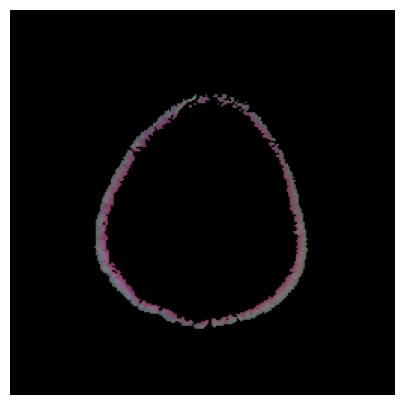

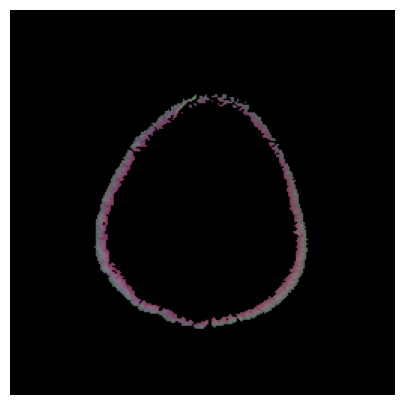

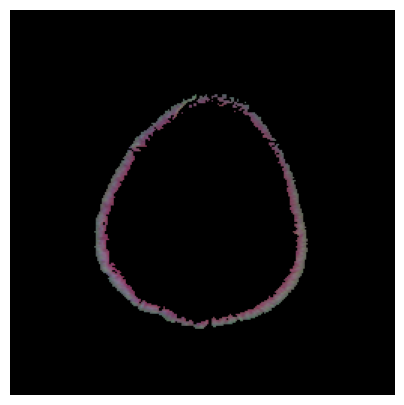

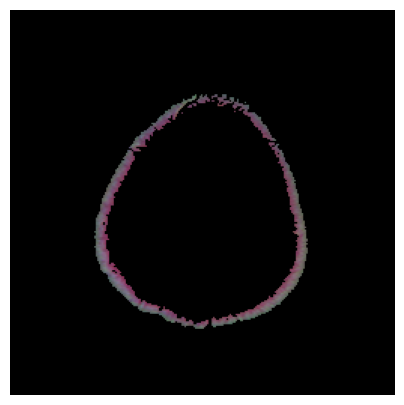

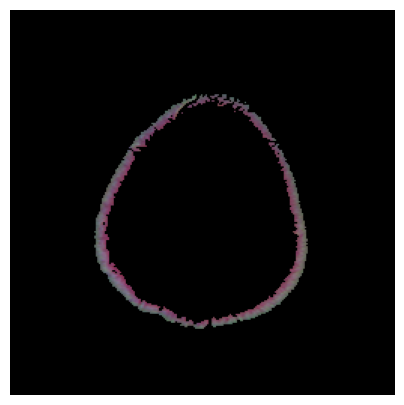

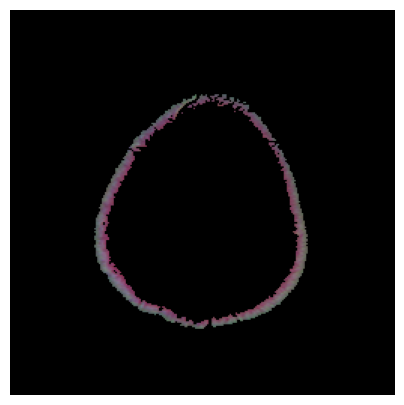

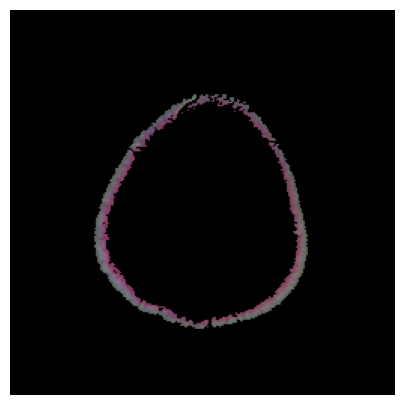

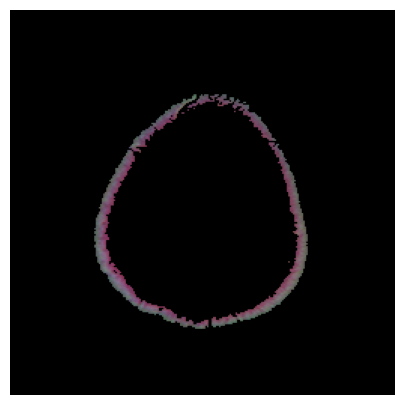

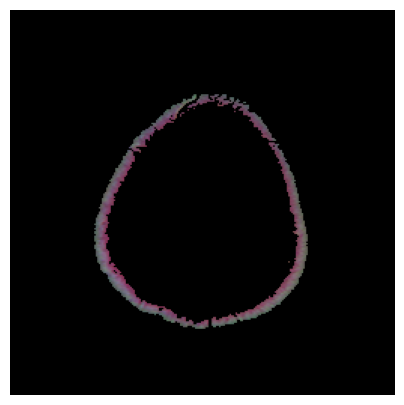

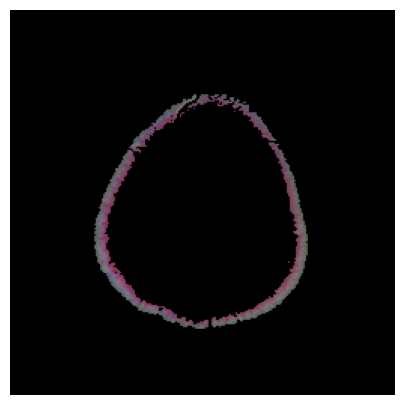

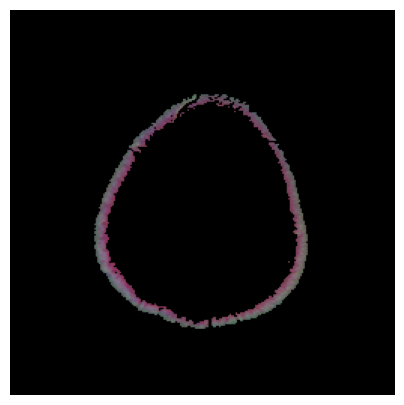

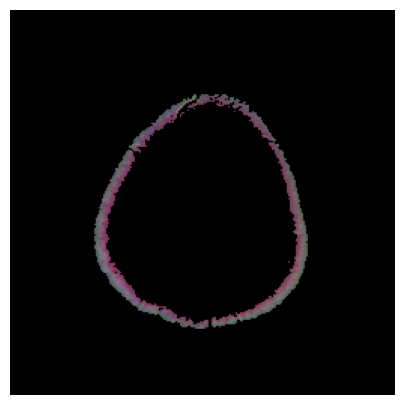

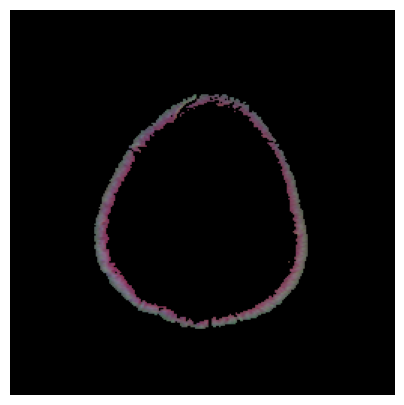

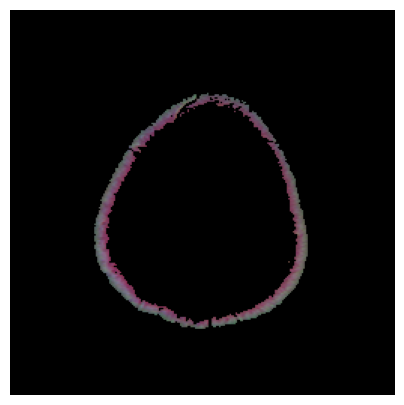

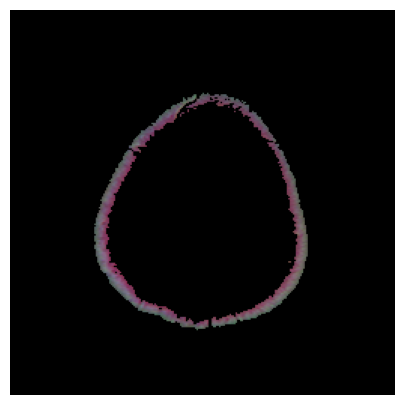

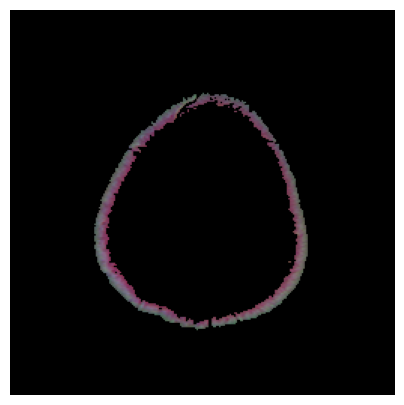

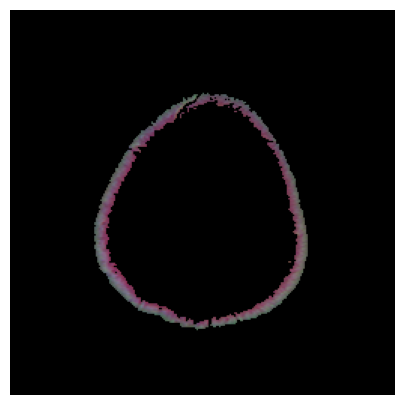

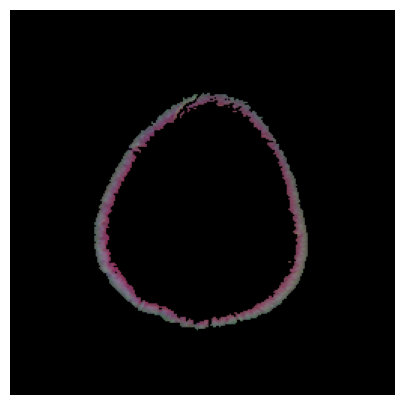

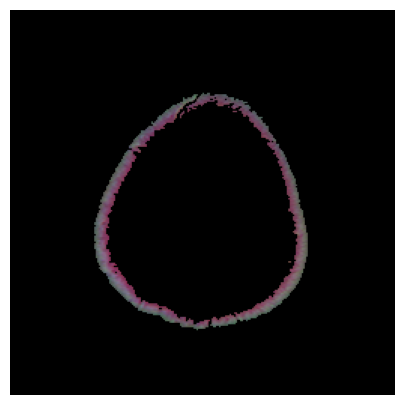

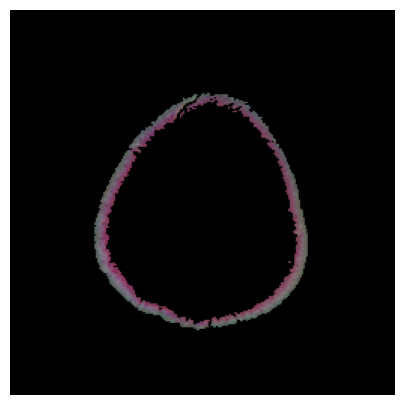

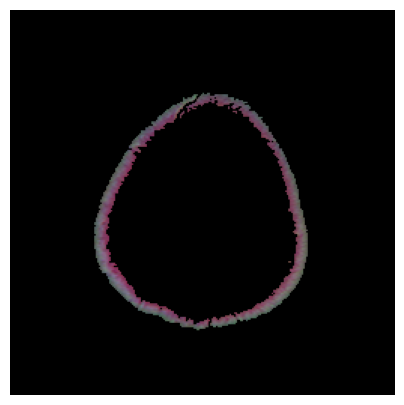

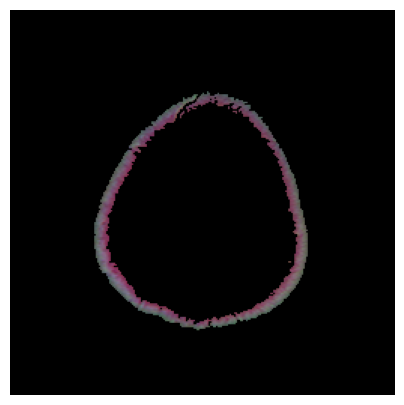

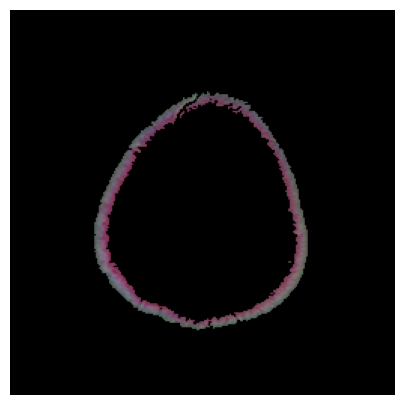

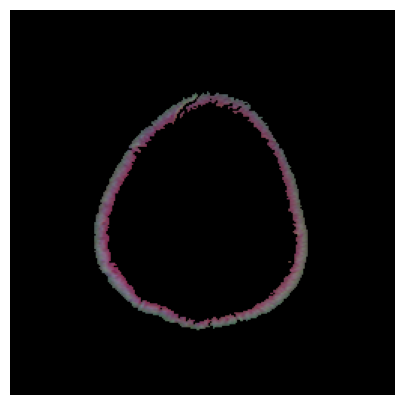

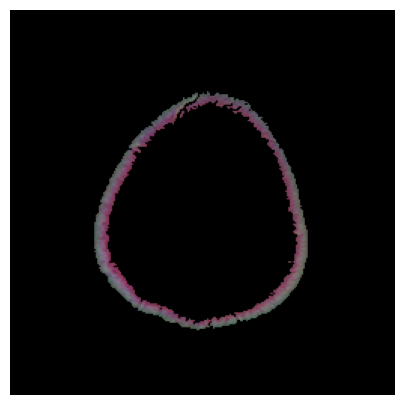

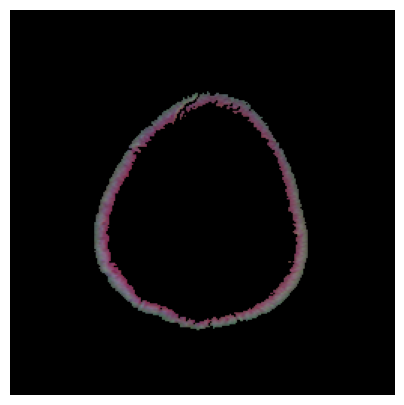

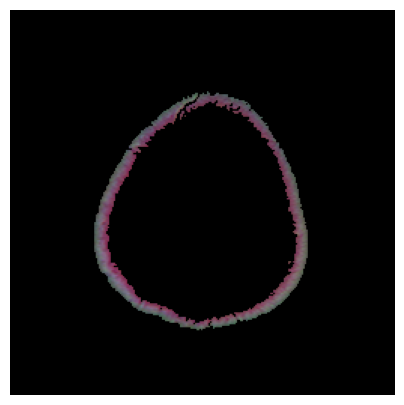

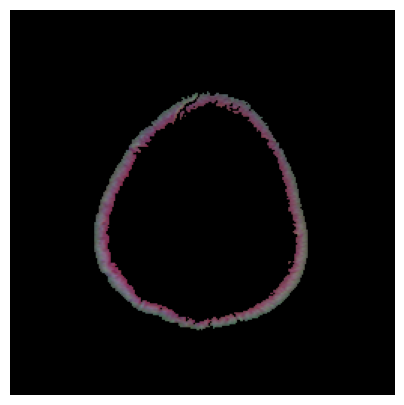

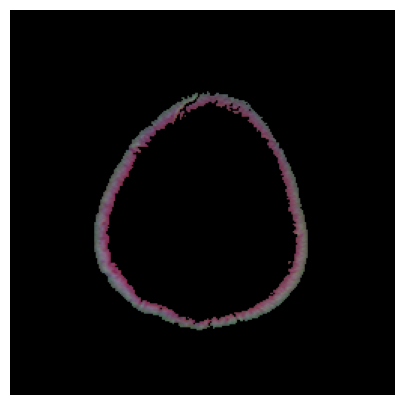

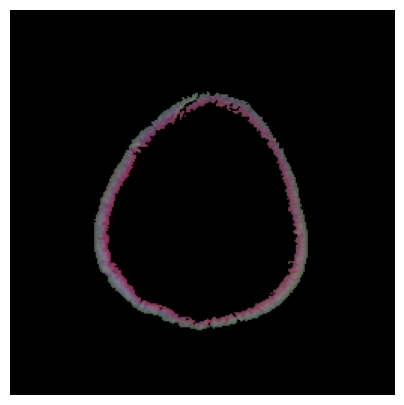

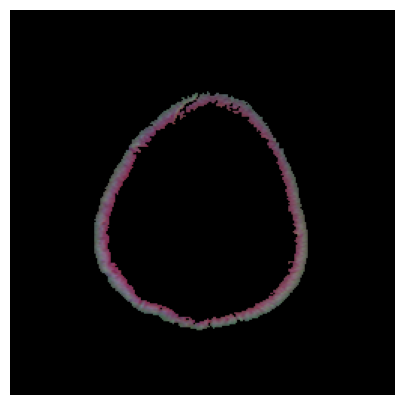

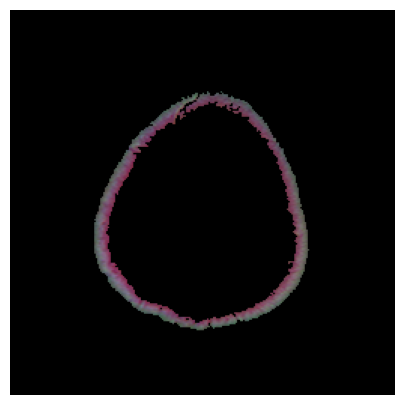

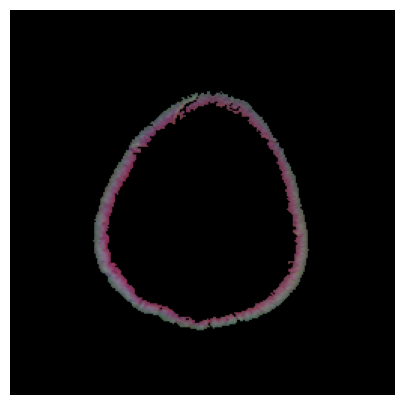

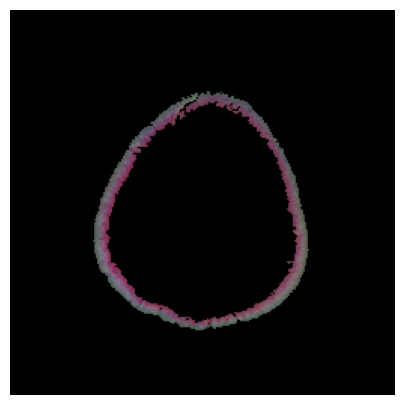

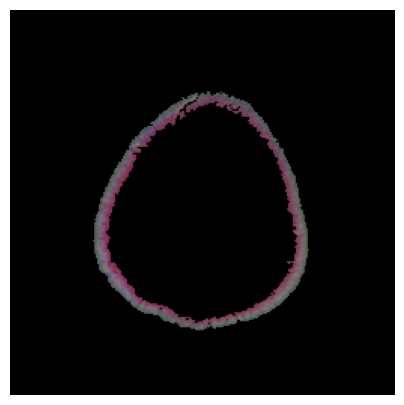

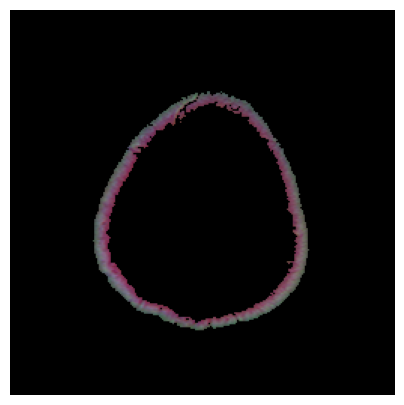

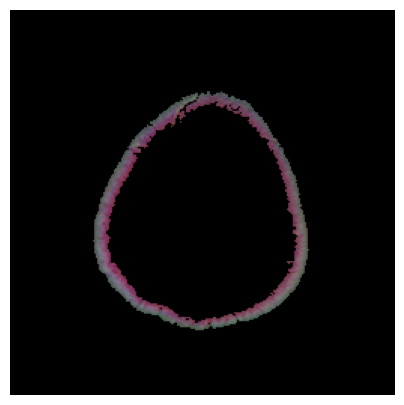

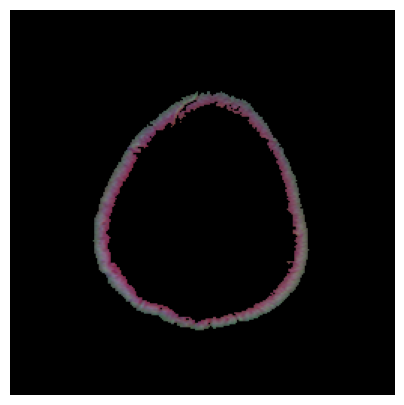

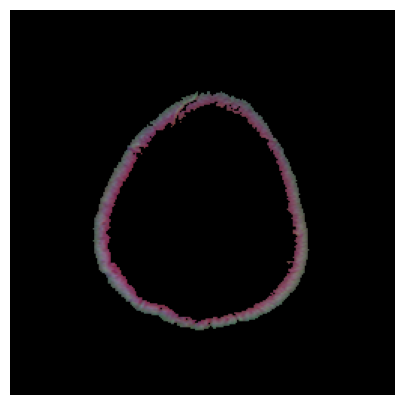

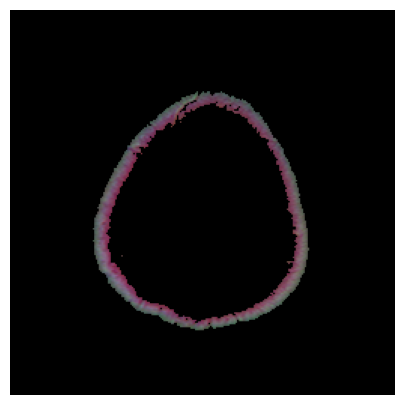

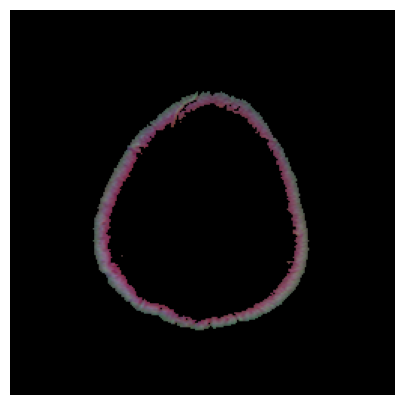

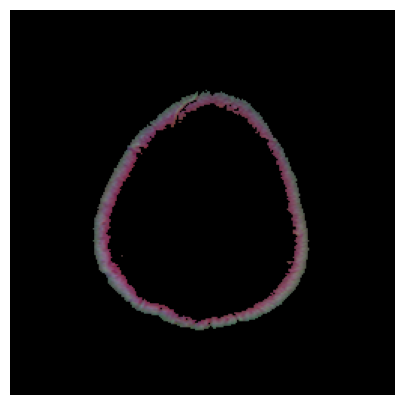

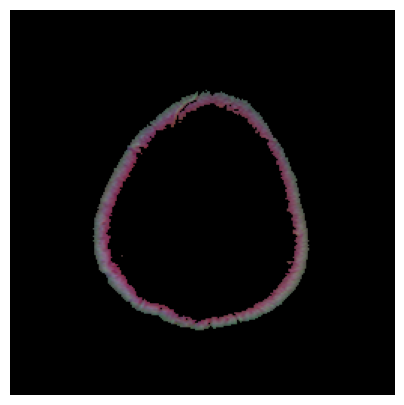

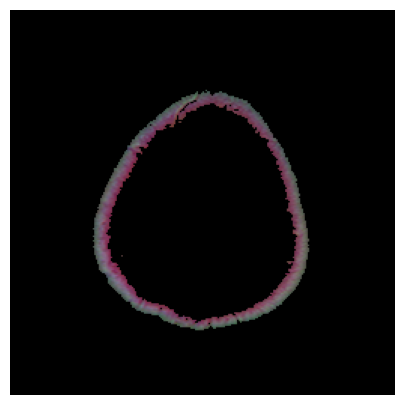

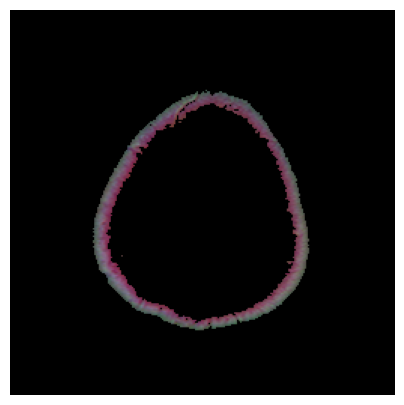

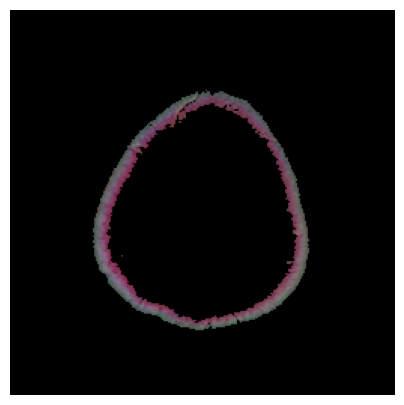

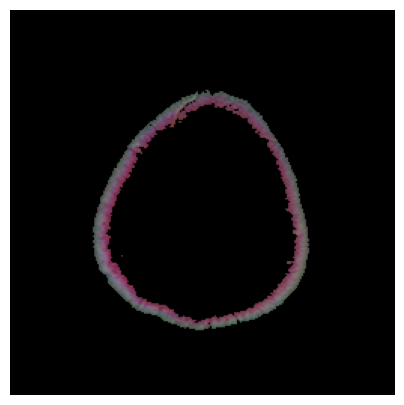

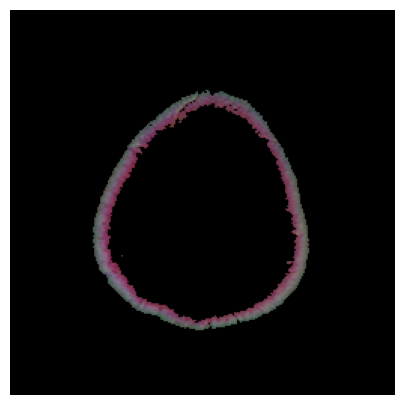

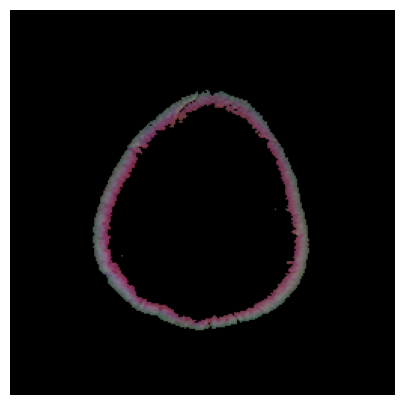

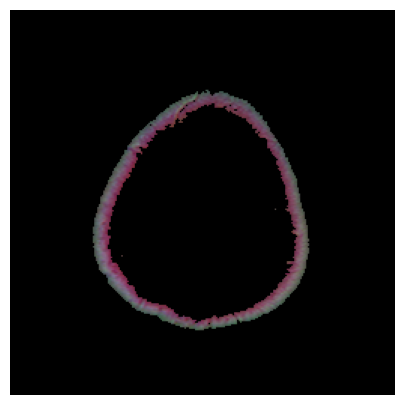

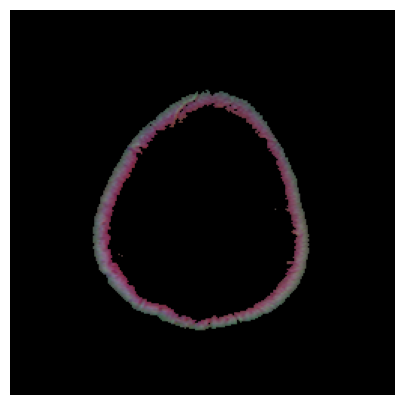

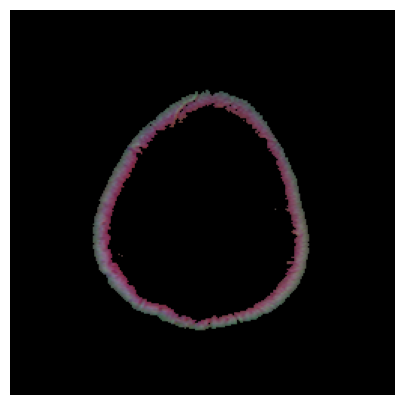

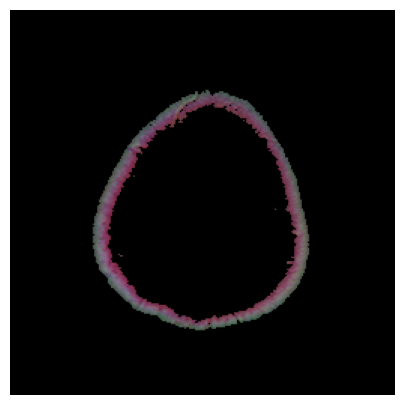

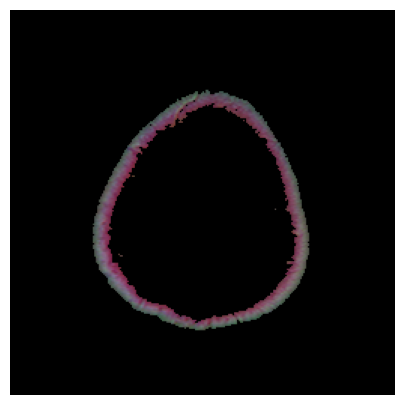

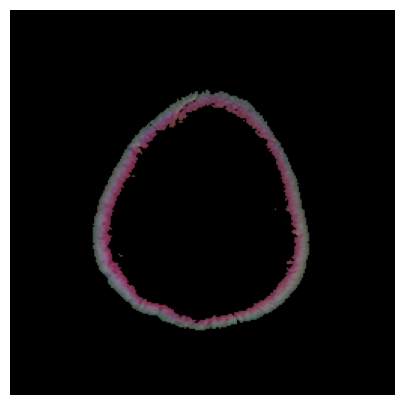

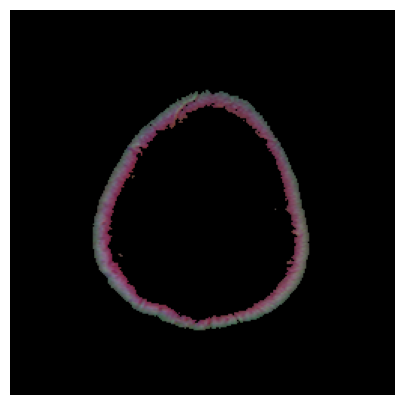

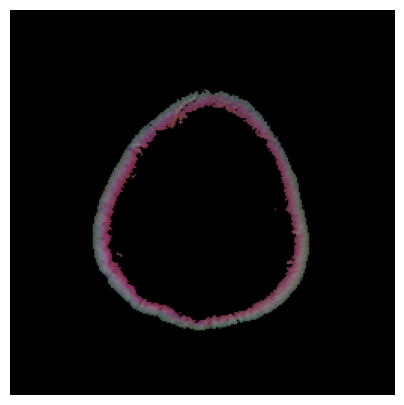

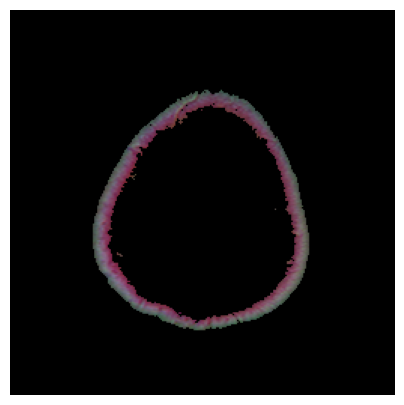

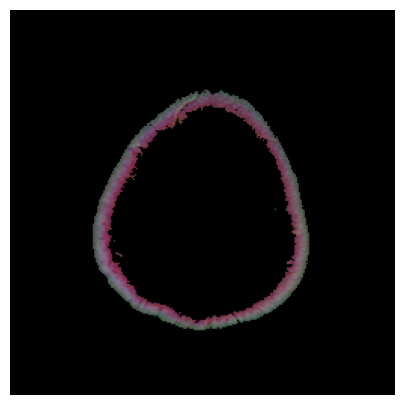

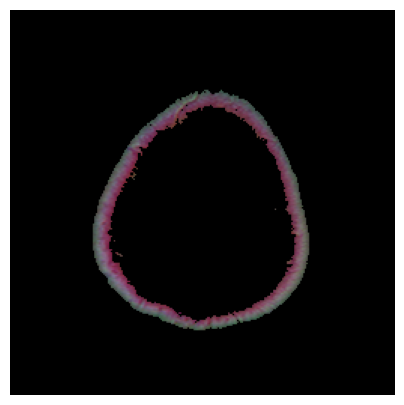

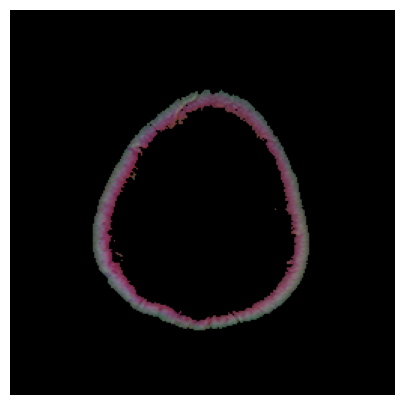

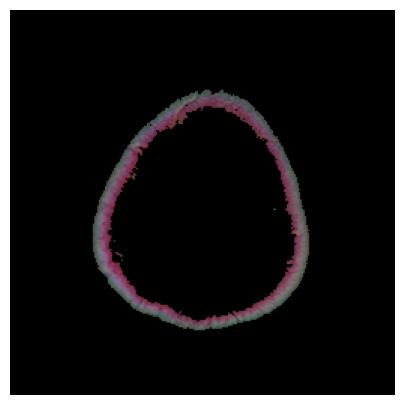

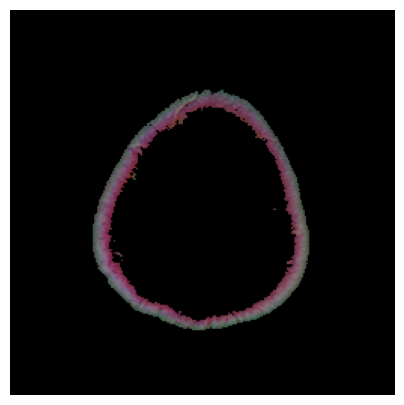

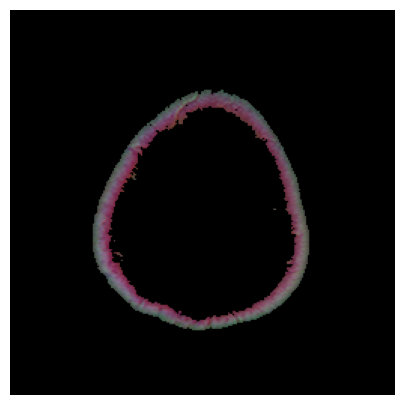

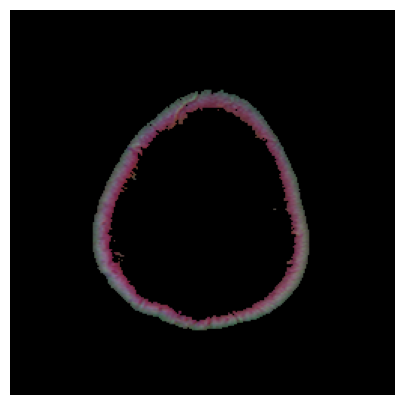

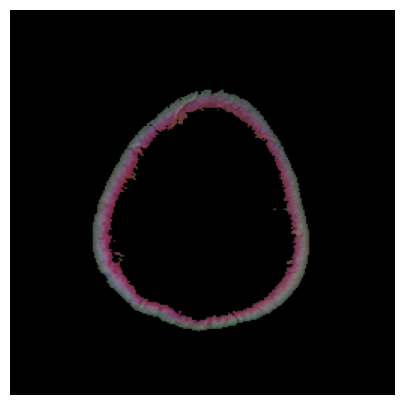

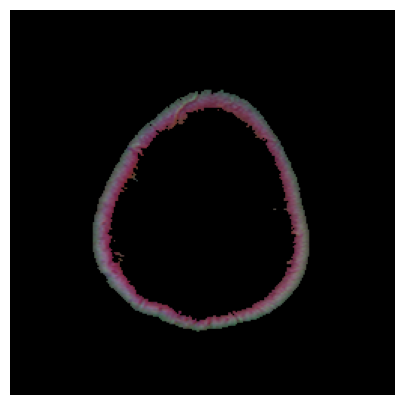

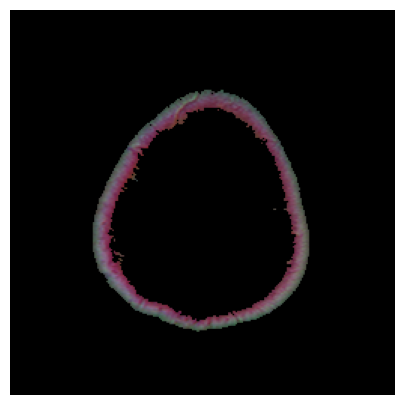

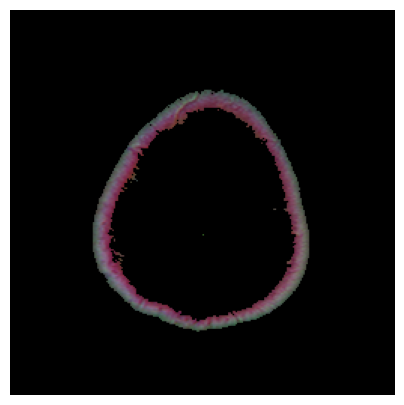

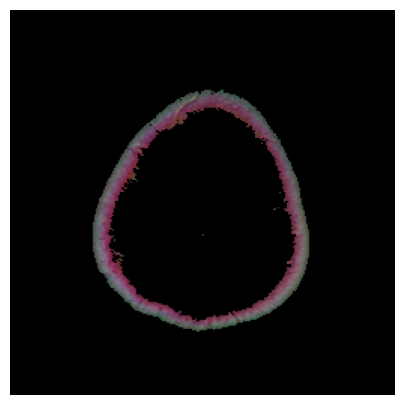

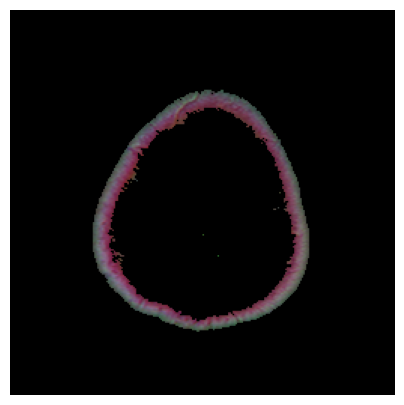

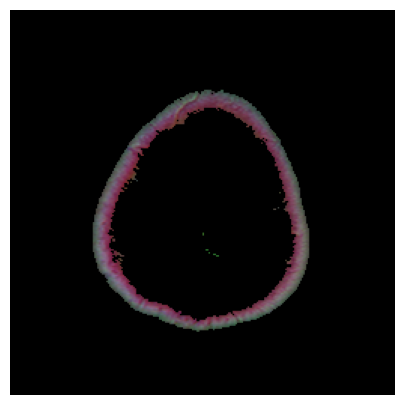

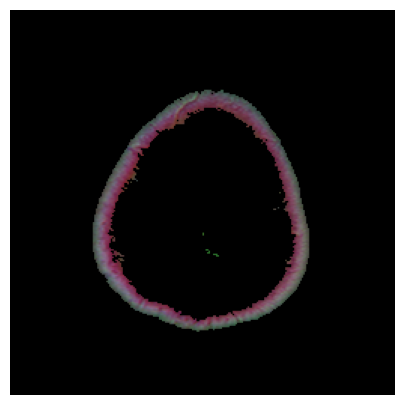

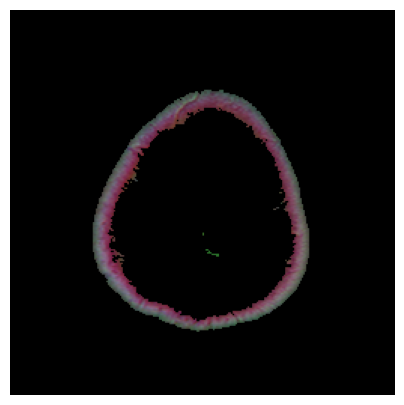

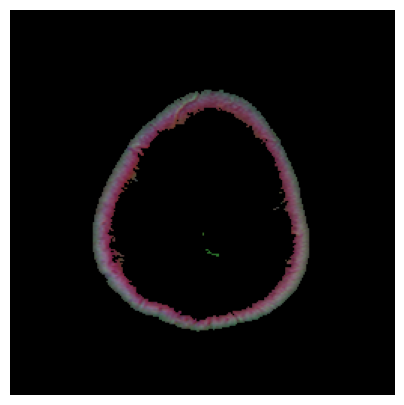

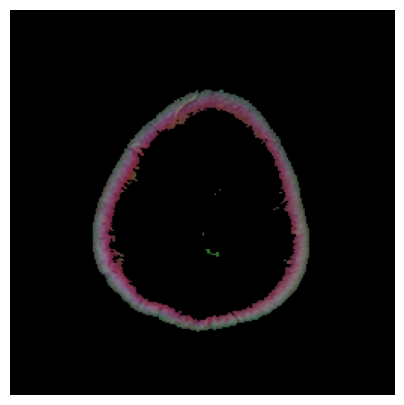

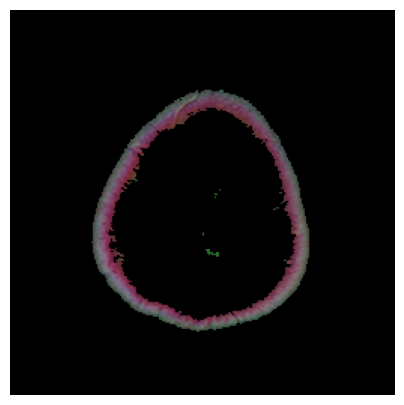

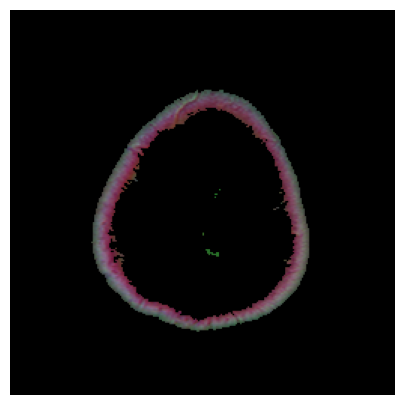

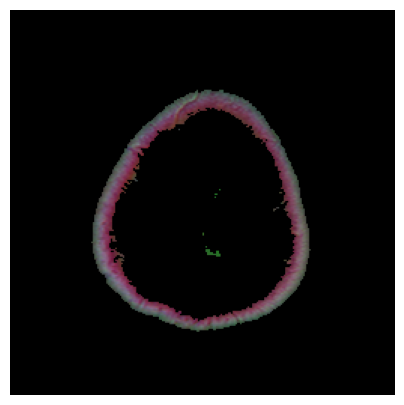

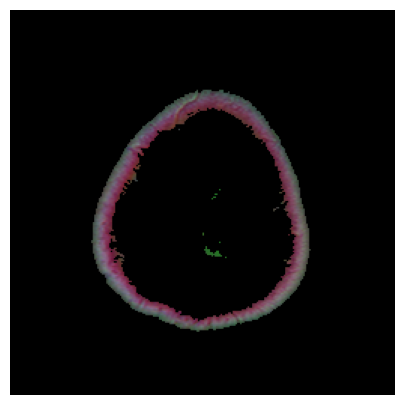

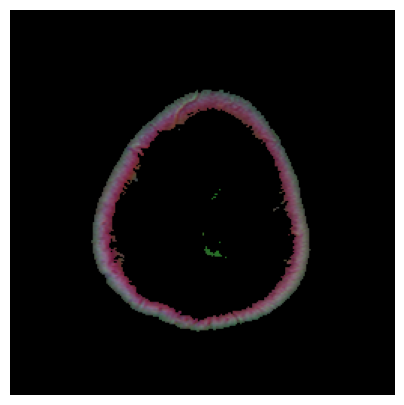

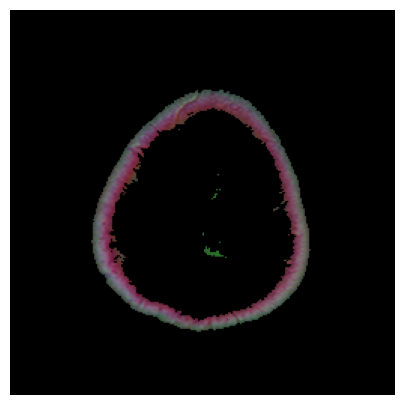

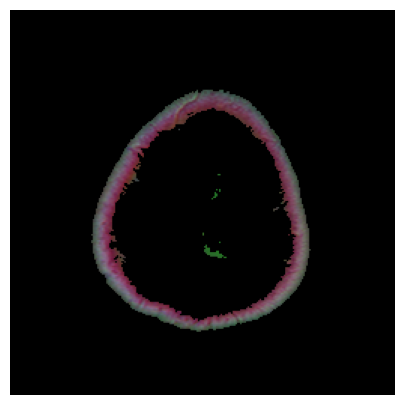

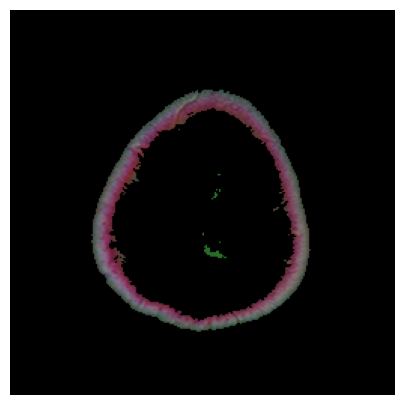

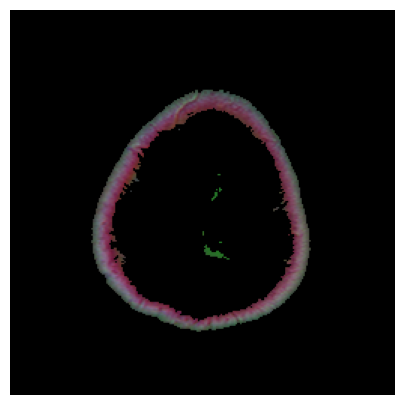

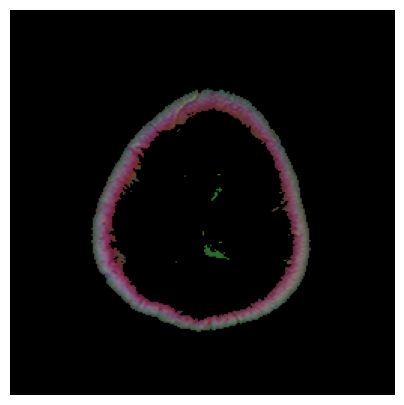

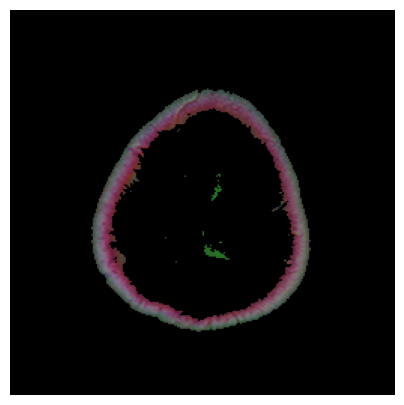

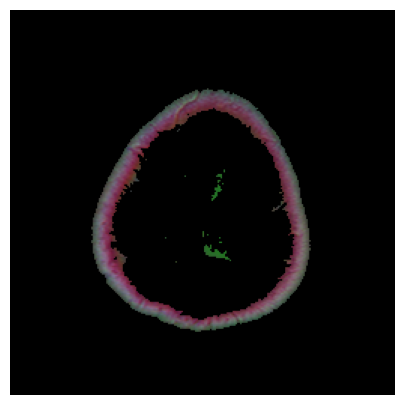

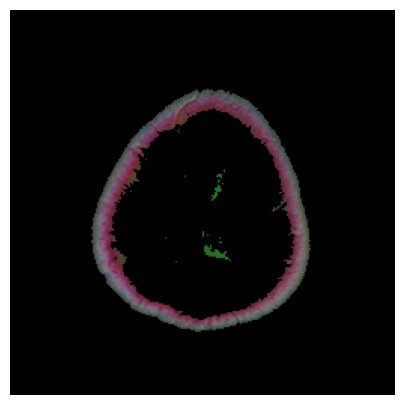

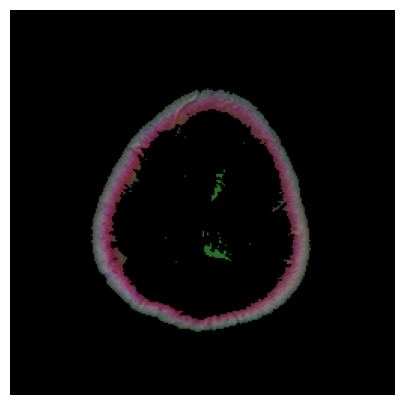

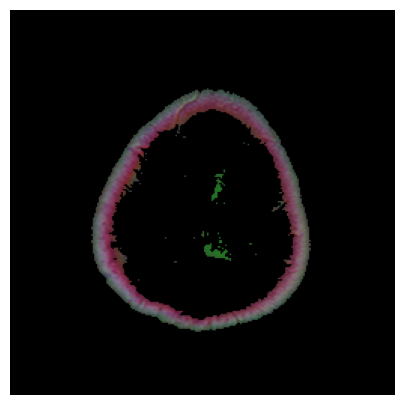

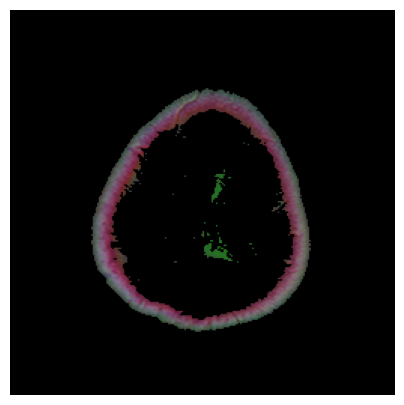

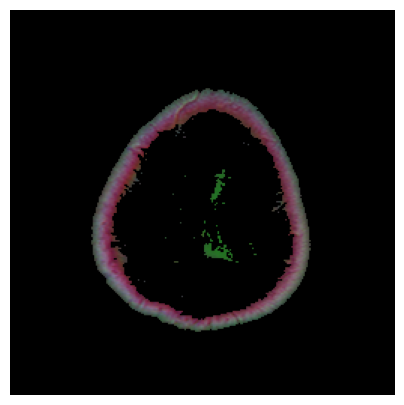

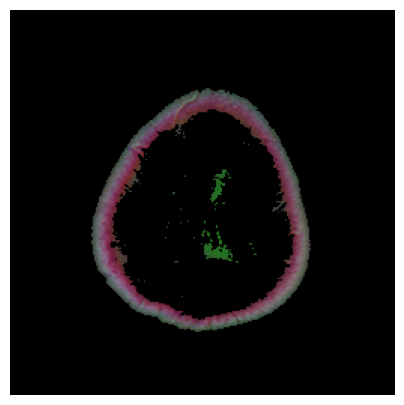

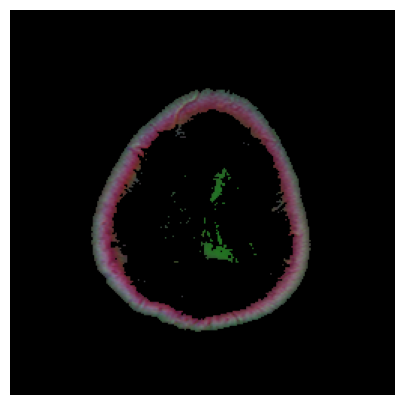

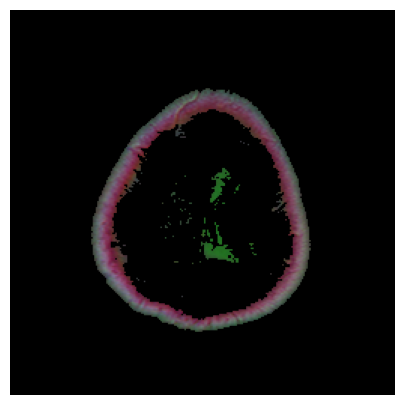

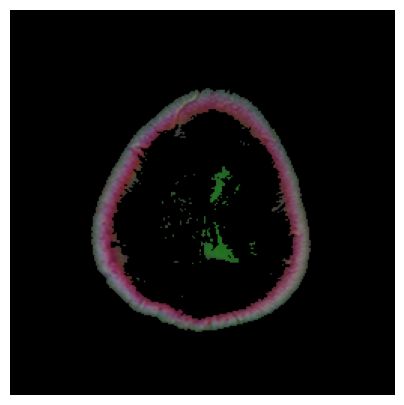

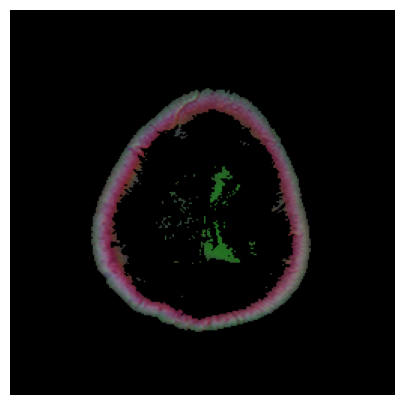

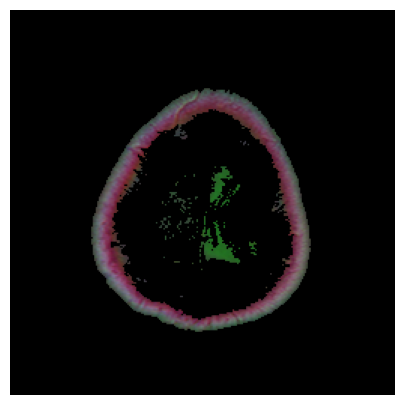

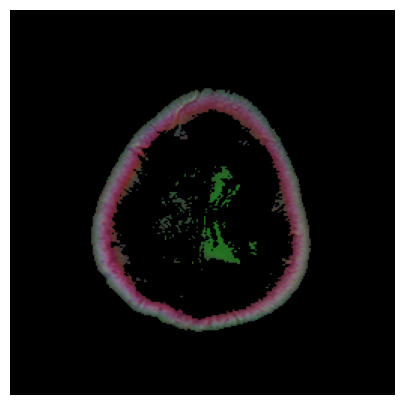

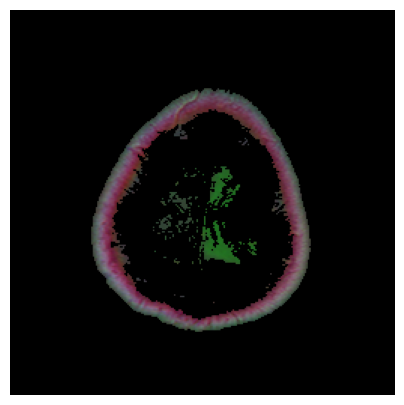

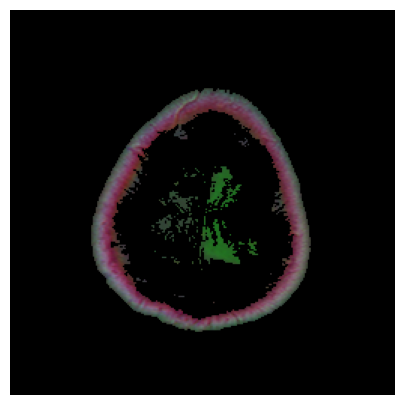

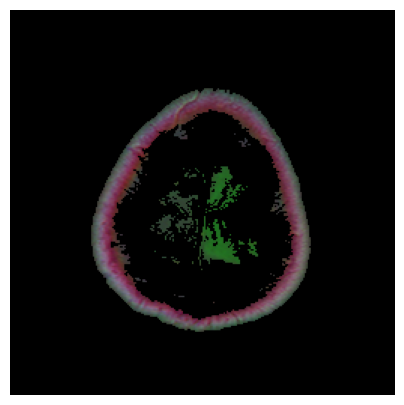

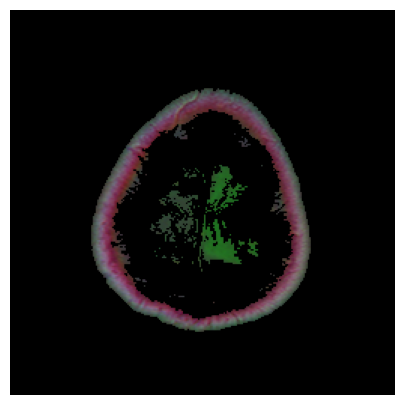

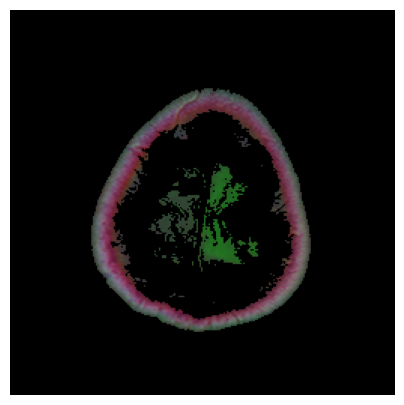

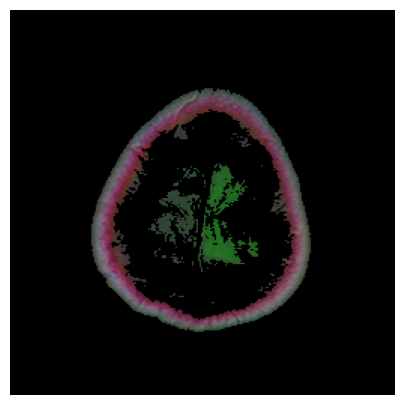

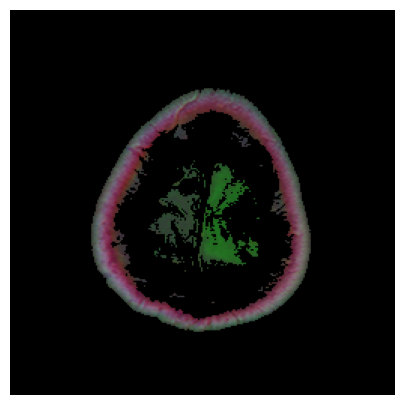

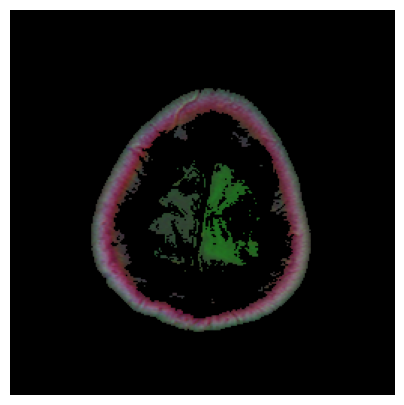

In [13]:
print(shap_value.data.shape)
average = []
for shap_value in shap_values['blur(64,64)']:
    average = (shap_value.data[0, :, :, 0] + shap_value.data[0, :, :, 1] + shap_value.data[0, :, :, 2]) / 3
levels = np.flip(np.unique(average))
print(average.shape)
masks = np.empty([256,256,3])
counter = 0
fig = plt.figure(figsize=(5, 5))
plt.imshow(img_array[0])
plt.axis("off")
for level in levels:
    counter = counter + 1
    pixels = np.where(average == level)
    masks[pixels[0], pixels[1], :] = True
    xd = np.where(masks, img_array[0], 0)
    fig = plt.figure(figsize=(5, 5))
    plt.imshow(xd)
    plt.axis("off")
    pre = model.predict(np.expand_dims(xd, axis=0))
    print(pre)
    argmax = np.argmax(pre, axis = 1)
    if (argmax == 1 and pre[0][argmax] > 0.5):
        print("out")
        break
        
xd99 = xd

(-0.5, 255.5, 255.5, -0.5)

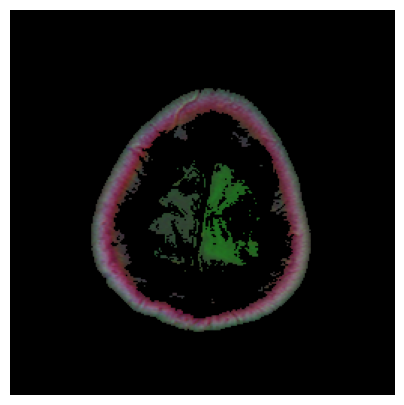

In [14]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(xd99)
plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

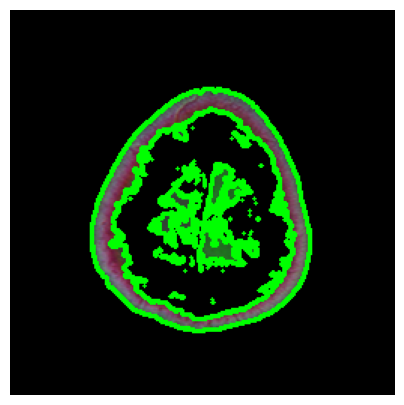

In [12]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(xd99)
plt.axis("off")

uint8


(-0.5, 255.5, 255.5, -0.5)

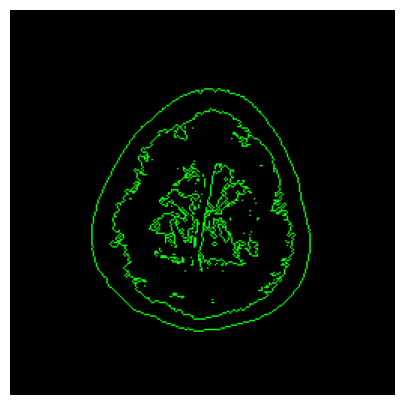

In [39]:
#fig = plt.figure(figsize=(5, 5))
#xd2 = np.where(xd == 0, 255, xd)
#plt.imshow(xd2)
#plt.axis("off")
xd3 = cv2.cvtColor(xd, cv2.COLOR_BGR2GRAY)
xd3  = (xd3*255).astype(np.uint8)
print(xd3.dtype)

ret, xd3 = cv2.threshold(xd3, 0, 255, cv2.THRESH_BINARY)
countours,hierarchy=cv2.findContours(xd3,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# draw contours
xd999 = xd
cv2.drawContours((xd999 * 255).astype(np.uint8), countours, -1, (0,255,0), 0)

fig = plt.figure(figsize=(5, 5))
plt.imshow(xd999.astype(np.uint8))
plt.axis("off")        

In [19]:
print(countours[0])

[[[129  52]]

 [[128  53]]

 [[127  53]]

 [[127  54]]

 [[126  55]]

 [[125  54]]

 [[125  53]]

 [[123  53]]

 [[122  54]]

 [[120  54]]

 [[119  55]]

 [[118  55]]

 [[117  56]]

 [[115  56]]

 [[114  57]]

 [[113  57]]

 [[111  59]]

 [[110  59]]

 [[109  60]]

 [[108  60]]

 [[105  63]]

 [[104  63]]

 [[102  65]]

 [[101  65]]

 [[101  66]]

 [[100  67]]

 [[ 99  67]]

 [[ 92  74]]

 [[ 91  74]]

 [[ 88  77]]

 [[ 87  77]]

 [[ 87  78]]

 [[ 82  83]]

 [[ 82  84]]

 [[ 79  87]]

 [[ 79  88]]

 [[ 77  90]]

 [[ 77  91]]

 [[ 75  93]]

 [[ 75  94]]

 [[ 73  96]]

 [[ 73  97]]

 [[ 72  98]]

 [[ 72  99]]

 [[ 71 100]]

 [[ 71 101]]

 [[ 69 103]]

 [[ 69 104]]

 [[ 68 105]]

 [[ 68 106]]

 [[ 67 107]]

 [[ 67 109]]

 [[ 65 111]]

 [[ 65 112]]

 [[ 64 113]]

 [[ 64 114]]

 [[ 63 115]]

 [[ 63 116]]

 [[ 62 117]]

 [[ 62 118]]

 [[ 61 119]]

 [[ 61 121]]

 [[ 60 122]]

 [[ 60 123]]

 [[ 59 124]]

 [[ 59 125]]

 [[ 58 126]]

 [[ 58 128]]

 [[ 57 129]]

 [[ 57 133]]

 [[ 56 134]]

 [[ 56